In [9]:
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

module_path = '/home/sbose/time-series-forecasting-federation'
sys.path.insert(0,module_path)
from files_for_appfl.comstock_dataloader import get_comstock
from files_for_appfl.loss import MSELoss
from files_for_appfl.metric import mape
from models.LSTM.LSTMAR import LSTMAR
from models.DARNN.DARNN import DARNN
from models.TRANSFORMER.Transformer import Transformer

# zero weight init
def zero_weights(model):
    for param in model.parameters():
        param.data.zero_()
        
# configure model and other stuff
lookahead, lookback = 4, 12
dtype = torch.float32
device = 'cuda'

num_clients = 12
test_every = 500
xformer_model_kwargs = {
    'x_size': 6,
    'y_size': 1,
    'u_size': 2,
    's_size': 7,
    'lookback': lookback,
    'lookahead': lookahead,
    'd_model' : 128,
    'e_layers' : 4,
    'd_layers' : 4,
    'dtype' : dtype
}
lstm_model_kwargs = {
    'x_size': 6,
    'y_size': 1,
    'u_size': 2,
    's_size': 7,
    'lookback': lookback,
    'lookahead': lookahead,
    'dtype' : dtype
}

# function to zero the weights for initialization
def zero_weights(model):
    for param in model.parameters():
        param.data.normal_()
        
# function to calculate norm of gradients
def calculate_gradient_norm(model):
    total_norm = 0
    for param in model.parameters():
        param_norm = param.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

In [19]:
def train_and_test(
    model_name, # pass as the name containe in a string
    model_kwargs,
    optim_name, # pass as the name containe in a string
    optim_kwargs,
    custom_str = 'Transformer, FullFeatureSet, LongTrain',
    normalize = 'True',
    display_time_idx = 500,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    seed = 42,
    BS = 32,
    steps = 1000,
    clip_grad = np.inf,
    ntype = 'minmax',
    xformer_dim = 128,
    lr = 1e-5
):
    
    # master function to train on data and produce output on test set 
    if 'model_dim' in model_kwargs:
        model_kwargs['model_dim'] = xformer_dim
    model = nn.DataParallel(eval(model_name)(**model_kwargs))
    model = model.to(device)
    
    optim = eval(optim_name)(model.parameters(), **{'lr':lr})
    loss_fn = MSELoss(ntype)
    
    elapsed = 0
    loss_record, mape_record = [], []
    
    # get and combine datasets
    train_set, test_set = [], []
    for bidx in range(num_clients):
        train, test = get_comstock(
            bldg_idx = bidx,
            lookback = lookback,
            lookahead = lookahead,
            dtype = dtype,
            normalize = normalize,
            normalize_type=ntype
        )
        train_set.append(train)
        test_set.append(test)
    train_set, test_set = ConcatDataset(train_set), ConcatDataset(test_set)
    torch.manual_seed(seed)
    train_loader = DataLoader(train_set, batch_size=BS, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=8096, shuffle=True)
    
    zero_weights(model)
    loss_record, mape_record, norm_record = [], [], []
    for inp, lab in (t:=tqdm(itertools.cycle(train_loader))):
    
        inp, lab = inp.to(device), lab.to(device)
        pred = model(inp)
        loss = loss_fn(lab,pred)
        optim.zero_grad()
        loss.backward()
        if not np.isinf(clip_grad) and clip_grad > 0:
            # clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        norm_record.append(calculate_gradient_norm(model))
        optim.step()
        # scheduler.step()    
        loss_record.append(loss.item())
        elapsed += 1
        
        t.set_description(f"On experiment {custom_str}, step {elapsed}, loss is {loss.item()}.")
        
        if elapsed % test_every == 0:
            mapes = []
            for inp,lab in test_loader:
                inp = inp.to(device)
                with torch.no_grad():
                    pred = model(inp)
                mapes.append(mape(lab.to('cpu').numpy(),pred.to('cpu').numpy(),normalization_type=ntype))
            metric = np.mean(np.array(mapes))
            mape_record.append(metric)
            print(f"On step {elapsed}, MAPE error is {metric} percent.")
            
        if elapsed == steps:
            break
    
    # plotting here
    fig, axs = plt.subplots(1, 4, figsize=(20,4))
    # plot losses
    loss_record = np.array(loss_record)
    axs[0].plot(np.arange(1,loss_record.size+1),np.array(loss_record))
    axs[0].set_xlim(1,loss_record.size)
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('MSE Loss')
    axs[0].set_title(f'Train Loss')
    axs[0].set_yscale('log')
    # plot norms
    norm_record = np.array(norm_record)
    axs[1].plot(np.arange(1,norm_record.size+1),np.array(norm_record))
    axs[1].set_xlim(1,norm_record.size)
    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('L2 Norm')
    axs[1].set_title(f'Gradient Norm')
    axs[1].set_yscale('log')
    # plot MAPEs
    mape_record = np.array(mape_record)
    axs[2].plot(np.arange(1,mape_record.size+1),np.array(mape_record))
    axs[2].set_xlim(1,mape_record.size)
    axs[2].set_xlabel(f'Steps x{test_every}')
    axs[2].set_ylabel(f'MAPE')
    axs[2].set_title(f'Test set.')
    # plot the test sets
    inputs, outputs = [], []
    for idx in range(display_time_idx):
        itm = test_set.__getitem__(idx)
        inputs.append(itm[0])
        outputs.append(itm[1].numpy())
    batched_input = torch.stack(inputs).to(dtype).to(device)
    with torch.no_grad():   
        batched_output = model(batched_input).to('cpu').numpy()
    preds = list(batched_output)
    plot_gt, plot_pred = [], []
    for idx in range(display_time_idx):
        minval, maxval = outputs[idx][-1,1], outputs[idx][-1,2]
        if ntype == 'minmax':
            # minmax
            plot_gt.append((outputs[idx][-1,0]-minval)/(maxval-minval))
        else:
            # z normalization
            plot_gt.append((outputs[idx][-1,0]-minval)/maxval)
        plot_pred.append(preds[idx][-1,0])
    plot_gt, plot_pred = np.array(plot_gt), np.array(plot_pred)
    axs[3].plot(np.arange(1,plot_gt.size+1),plot_gt,label='ground truth')
    axs[3].plot(np.arange(1,plot_pred.size+1),plot_pred,label='prediction')
    axs[3].set_xlim(1,plot_pred.size)
    axs[3].set_xlabel('Time index')
    axs[3].set_ylabel('kWh')
    axs[3].legend()
    axs[3].set_title(f'Reconstruction')
    
    plt.suptitle(f'BS={BS}, lr={lr}, token={xformer_dim}')
    
    os.makedirs('centralized_results',exist_ok=True)
    plt.savefig(f'centralized_results/BS_{BS}_lr_{lr}_token_{xformer_dim}.pdf',format='pdf',bbox_inches='tight')
    np.savez_compressed(f'centralized_results/BS_{BS}_lr_{lr}_token_{xformer_dim}.npz',loss_record=loss_record, mape_record=mape_record,norm_record=norm_record,preds=preds,outputs=outputs)
    
    return outputs, preds

On experiment Transformer, step 502, loss is 9.9516019821167.: : 502it [00:45,  1.50s/it]   

On step 500, MAPE error is 232.8818277879195 percent.


On experiment Transformer, step 1000, loss is 9.28726577758789.: : 999it [01:31, 10.96it/s] 

On step 1000, MAPE error is 221.3593764738603 percent.


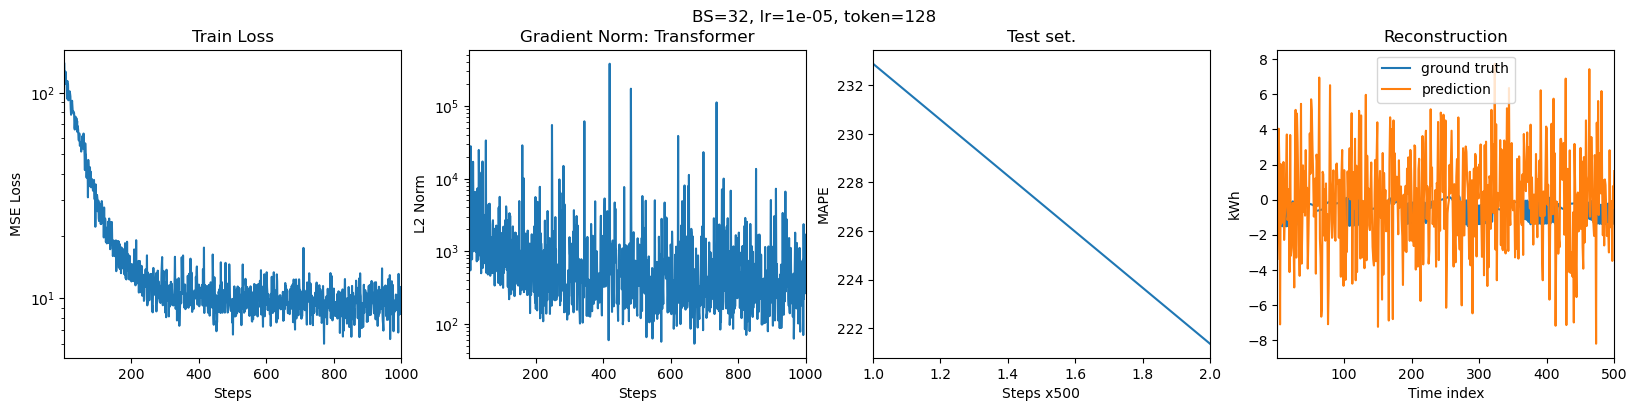

In [20]:
u = train_and_test(
    'Transformer', # pass as the name containe in a string
    lstm_model_kwargs,
    'torch.optim.SGD', # pass as the name containe in a string
    {'lr': 1e-3},
    'Transformer',
    True,
    steps=1000,
    ntype='z'
)

In [2]:
# o,p = train_and_test(
#     'LSTMAR', # pass as the name containe in a string
#     lstm_model_kwargs,
#     'torch.optim.SGD', # pass as the name containe in a string
#     {'lr': 1e-3},
#     'SGD LSTM Normalized Clipped',
#     True,
#     steps=3000,
#     clip_grad = 1e+3
# )

On experiment SGD LSTM Unnormalized Clipped, step 508, loss is 33.68803405761719.: : 504it [00:27,  1.48it/s] 

On step 500, MAPE error is 158.13258344476873 percent.


On experiment SGD LSTM Unnormalized Clipped, step 1007, loss is 72.48713684082031.: : 1004it [00:54,  1.16it/s] 

On step 1000, MAPE error is 149.99990246512672 percent.


On experiment SGD LSTM Unnormalized Clipped, step 1506, loss is 294.5087890625.: : 1504it [01:21,  1.34it/s]    

On step 1500, MAPE error is 199.12163344296542 percent.


On experiment SGD LSTM Unnormalized Clipped, step 2007, loss is 185.55596923828125.: : 2005it [01:49,  1.31it/s]

On step 2000, MAPE error is 170.67030451514503 percent.


On experiment SGD LSTM Unnormalized Clipped, step 2507, loss is 137.44459533691406.: : 2504it [02:16,  1.25it/s]

On step 2500, MAPE error is 178.27181165868586 percent.


On experiment SGD LSTM Unnormalized Clipped, step 3000, loss is 90.23136901855469.: : 2999it [02:43, 18.36it/s] 

On step 3000, MAPE error is 146.87574018131602 percent.


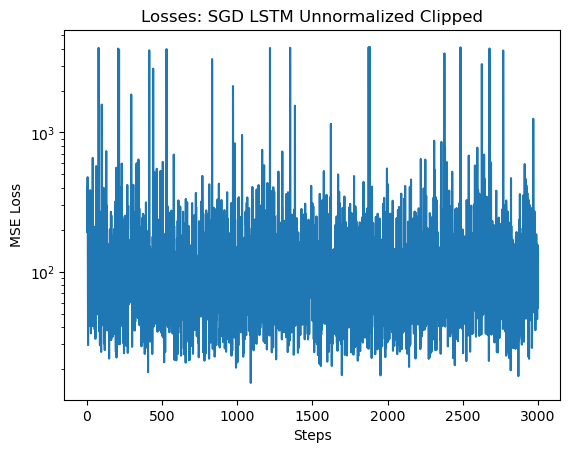

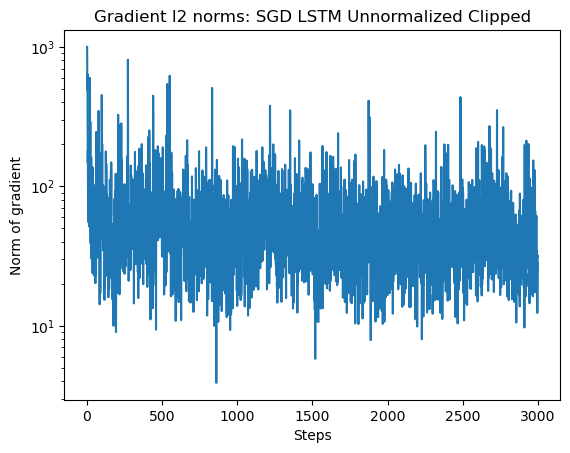

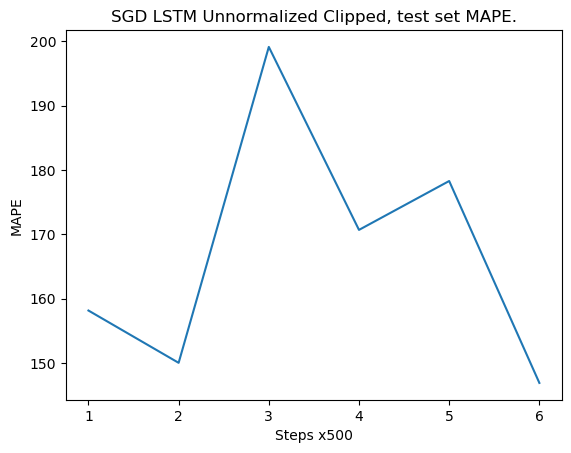

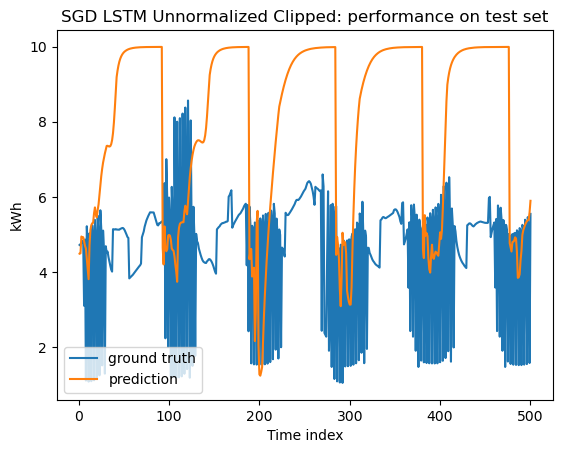

In [ ]:
# o,p = train_and_test(
#     'LSTMAR', # pass as the name containe in a string
#     lstm_model_kwargs,
#     'torch.optim.SGD', # pass as the name containe in a string
#     {'lr': 1e-3},
#     'SGD LSTM Unnormalized Clipped',
#     False,
#     steps=3000,
#     clip_grad = 1e+3
# )

On experiment Adam LSTM Normalized, step 508, loss is 0.22147820889949799.: : 506it [00:26,  1.75it/s]

On step 500, MAPE error is 405.17605434764516 percent.


On experiment Adam LSTM Normalized, step 1007, loss is 0.10571499168872833.: : 1006it [00:52,  1.46it/s] 

On step 1000, MAPE error is 237.38584951920942 percent.


On experiment Adam LSTM Normalized, step 1507, loss is 0.03428267687559128.: : 1505it [01:18,  1.40it/s] 

On step 1500, MAPE error is 176.01038217544556 percent.


On experiment Adam LSTM Normalized, step 2007, loss is 0.04485167935490608.: : 2007it [01:44,  1.46it/s] 

On step 2000, MAPE error is 156.24144077301025 percent.


On experiment Adam LSTM Normalized, step 2506, loss is 0.024898570030927658.: : 2504it [02:10,  1.50it/s]

On step 2500, MAPE error is 126.84993202036077 percent.


On experiment Adam LSTM Normalized, step 3000, loss is 0.012572534382343292.: : 2999it [02:37, 19.09it/s] 

On step 3000, MAPE error is 104.79759303006259 percent.


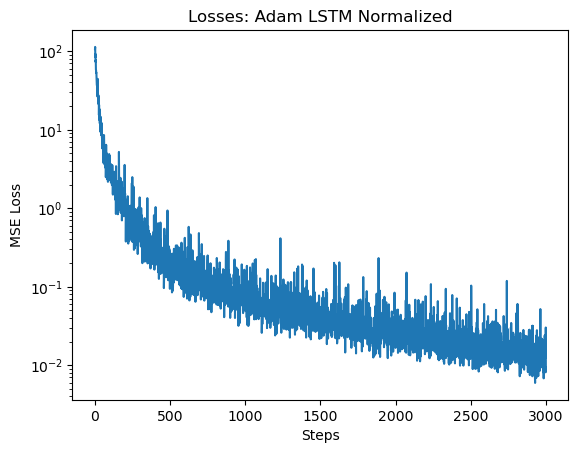

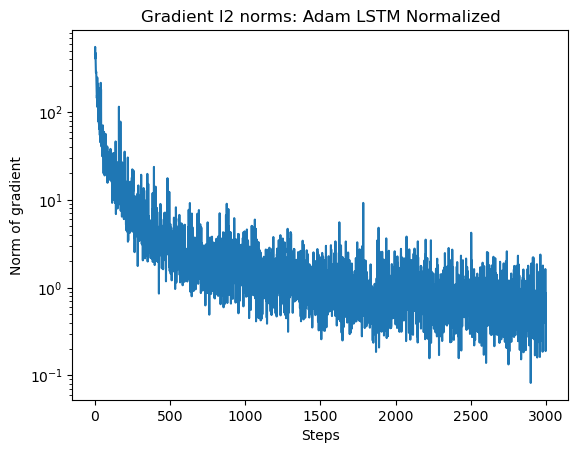

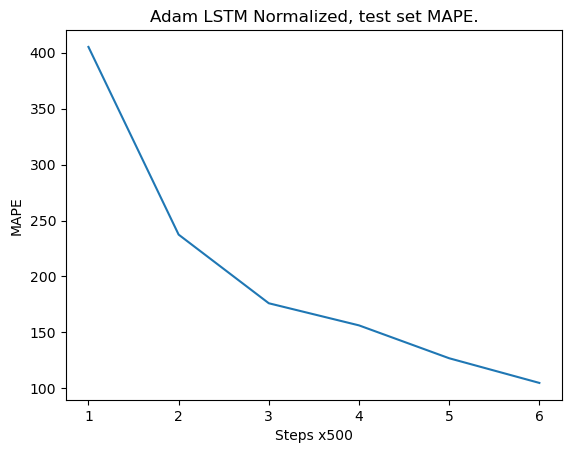

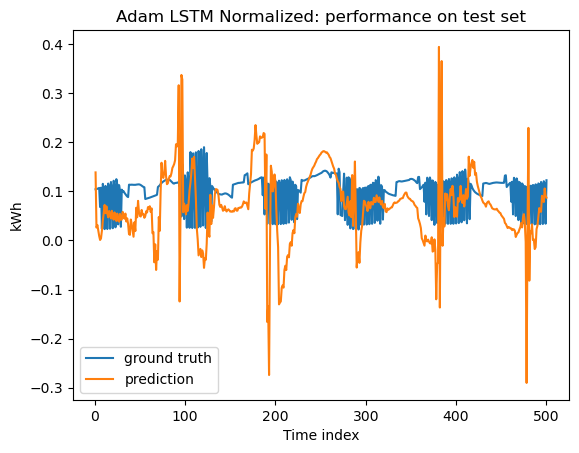

In [ ]:
# o,p = train_and_test(
#     'LSTMAR', # pass as the name containe in a string
#     lstm_model_kwargs,
#     'torch.optim.Adam', # pass as the name containe in a string
#     {'lr': 1e-3},
#     'Adam LSTM Normalized',
#     True,
#     steps = 3000
# )

On experiment SGD DARNN Unnormalized, step 502, loss is 121.69941711425781.: : 502it [00:52,  1.76s/it]

On step 500, MAPE error is 214.64112021706322 percent.


On experiment SGD DARNN Unnormalized, step 1002, loss is 63.89628219604492.: : 1002it [01:43,  1.56s/it] 

On step 1000, MAPE error is 235.36075245250356 percent.


On experiment SGD DARNN Unnormalized, step 1502, loss is 103.90351867675781.: : 1502it [02:34,  1.57s/it]

On step 1500, MAPE error is 242.37056862224233 percent.


On experiment SGD DARNN Unnormalized, step 2002, loss is 34.97044372558594.: : 2002it [03:26,  1.56s/it] 

On step 2000, MAPE error is 236.87420324845746 percent.


On experiment SGD DARNN Unnormalized, step 2502, loss is 25.650358200073242.: : 2502it [04:17,  1.58s/it]

On step 2500, MAPE error is 240.8163699236783 percent.


On experiment SGD DARNN Unnormalized, step 3000, loss is 101.85758972167969.: : 2999it [05:09,  9.69it/s]

On step 3000, MAPE error is 234.54354459589177 percent.


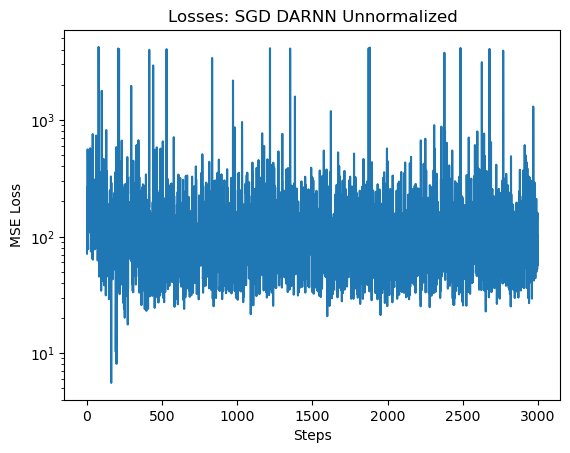

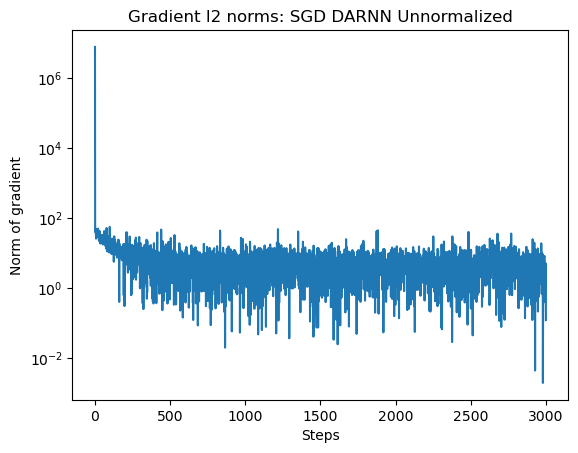

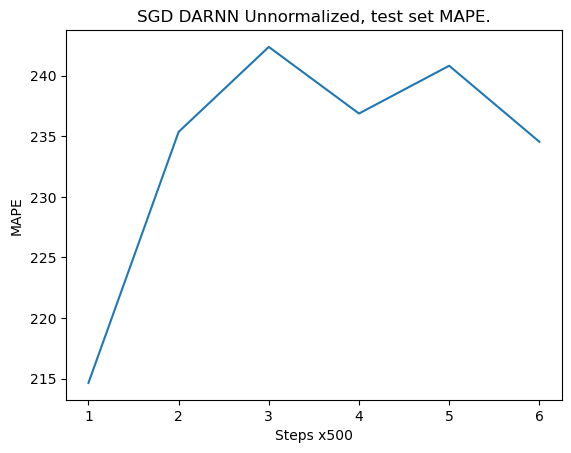

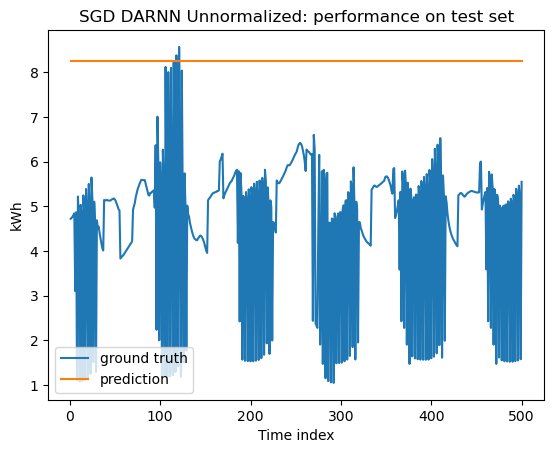

In [ ]:
# o,p = train_and_test(
#     'DARNN', # pass as the name containe in a string
#     lstm_model_kwargs,
#     'torch.optim.SGD', # pass as the name containe in a string
#     {'lr': 1e-3},
#     'SGD DARNN Unnormalized',
#     False,
#     steps=3000,
#     BS=32,
# )

On experiment SGD DARNN Unnormalized Clipped, step 502, loss is 114.57881164550781.: : 502it [00:50,  1.57s/it]

On step 500, MAPE error is 204.4148856943304 percent.


On experiment SGD DARNN Unnormalized Clipped, step 1002, loss is 59.853111267089844.: : 1002it [01:41,  1.56s/it]

On step 1000, MAPE error is 184.1883746060458 percent.


On experiment SGD DARNN Unnormalized Clipped, step 1502, loss is 96.6607894897461.: : 1502it [02:32,  1.57s/it]  

On step 1500, MAPE error is 184.91747270930898 percent.


On experiment SGD DARNN Unnormalized Clipped, step 2002, loss is 31.842090606689453.: : 2002it [03:24,  1.56s/it]

On step 2000, MAPE error is 173.56167489832097 percent.


On experiment SGD DARNN Unnormalized Clipped, step 2502, loss is 21.825124740600586.: : 2502it [04:17,  1.56s/it]

On step 2500, MAPE error is 172.70406159487638 percent.


On experiment SGD DARNN Unnormalized Clipped, step 3000, loss is 94.20824432373047.: : 2999it [05:08,  9.71it/s] 

On step 3000, MAPE error is 168.62225749275902 percent.


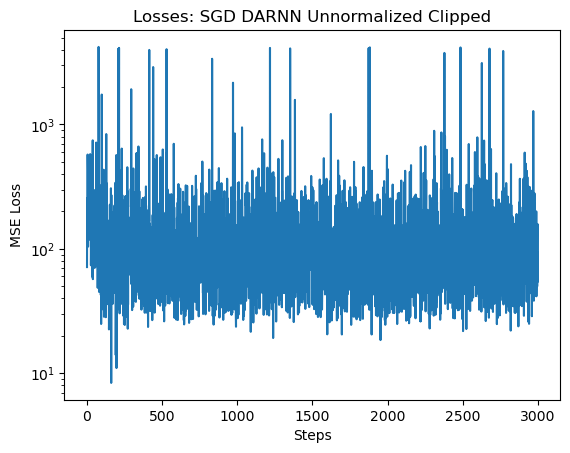

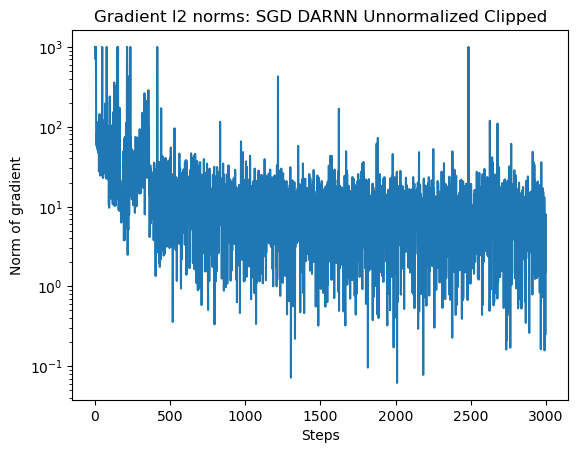

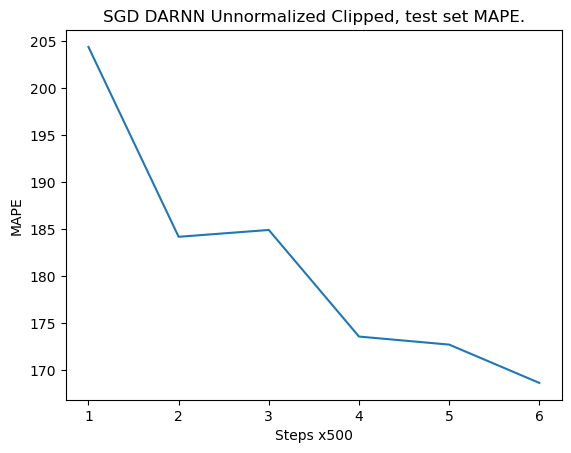

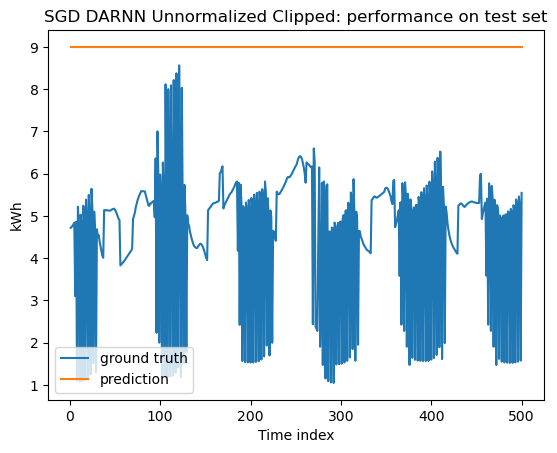

In [ ]:
# o,p = train_and_test(
#     'DARNN', # pass as the name containe in a string
#     lstm_model_kwargs,
#     'torch.optim.SGD', # pass as the name containe in a string
#     {'lr': 1e-3},
#     'SGD DARNN Unnormalized Clipped',
#     False,
#     steps=3000,
#     BS=32,
#     clip_grad=1e+3
# )

On experiment Adam DARNN Unnormalized Clipped BS64, step 502, loss is 99.35350036621094.: : 502it [00:54,  1.56s/it] 

On step 500, MAPE error is 124.66058297590776 percent.


On experiment Adam DARNN Unnormalized Clipped BS64, step 1002, loss is 137.7173614501953.: : 1002it [01:49,  1.59s/it] 

On step 1000, MAPE error is 121.86010425741023 percent.


On experiment Adam DARNN Unnormalized Clipped BS64, step 1502, loss is 192.89328002929688.: : 1502it [02:45,  1.59s/it]

On step 1500, MAPE error is 141.51940562508324 percent.


On experiment Adam DARNN Unnormalized Clipped BS64, step 2002, loss is 306.796142578125.: : 2002it [03:39,  1.56s/it]  

On step 2000, MAPE error is 117.57619055834684 percent.


On experiment Adam DARNN Unnormalized Clipped BS64, step 2502, loss is 167.6818084716797.: : 2502it [04:34,  1.58s/it] 

On step 2500, MAPE error is 106.07622211629695 percent.


On experiment Adam DARNN Unnormalized Clipped BS64, step 3000, loss is 134.44180297851562.: : 2999it [05:28,  9.13it/s]

On step 3000, MAPE error is 93.54979720982638 percent.


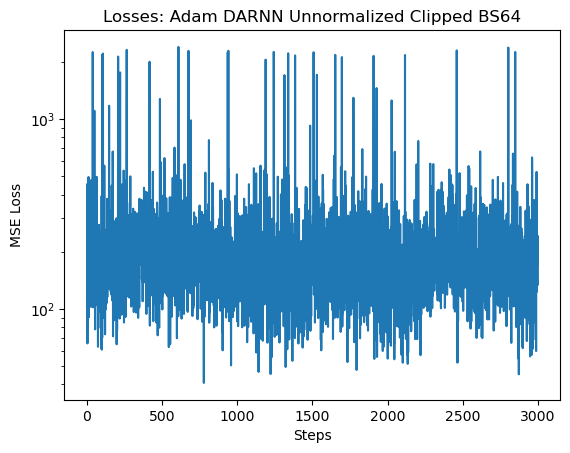

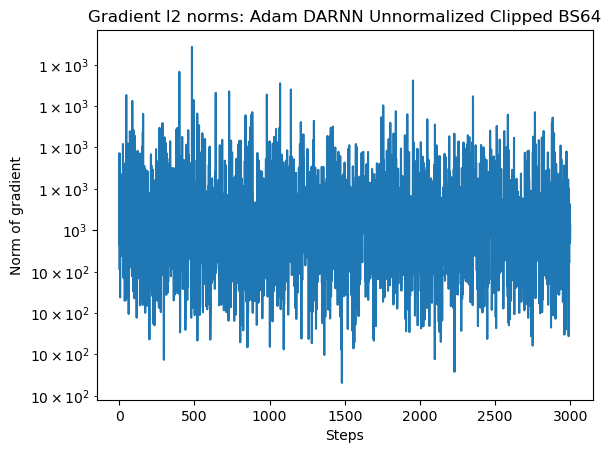

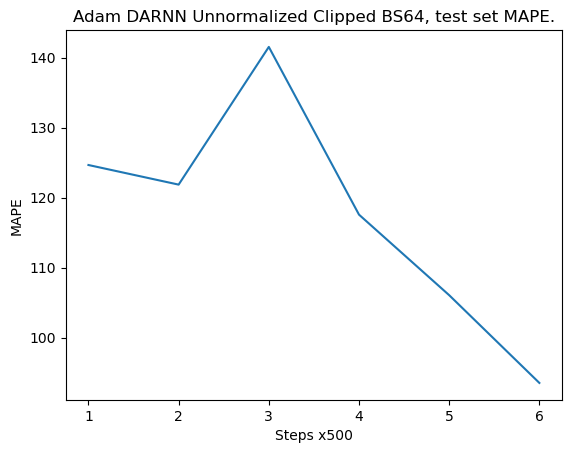

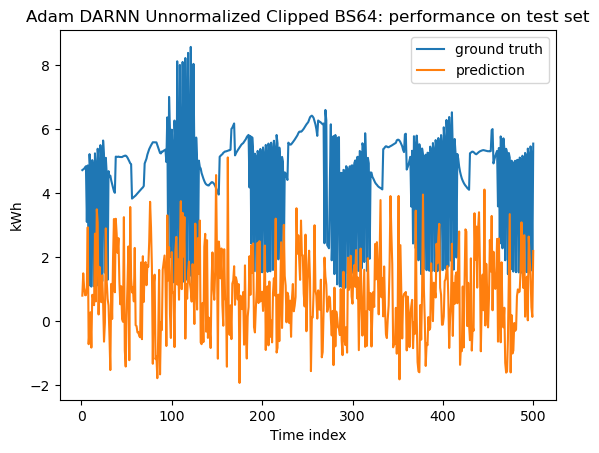

In [ ]:
# o,p = train_and_test(
#     'DARNN', # pass as the name containe in a string
#     lstm_model_kwargs,
#     'torch.optim.Adam', # pass as the name containe in a string
#     {'lr': 1e-3},
#     'Adam DARNN Unnormalized Clipped BS64',
#     False,
#     steps=3000,
#     clip_grad=1e+3,
#     BS=64,
# )

On experiment AdamW Transformer Normalized Clipped, step 503, loss is 6.1561737060546875.: : 502it [00:50,  1.66s/it]

On step 500, MAPE error is 2331.739616394043 percent.


On experiment AdamW Transformer Normalized Clipped, step 1001, loss is 6.055744171142578.: : 1000it [01:37,  2.09s/it]

On step 1000, MAPE error is 2025.0755483453925 percent.


On experiment AdamW Transformer Normalized Clipped, step 1502, loss is 4.213073253631592.: : 1502it [02:25,  1.50s/it] 

On step 1500, MAPE error is 1826.3404846191406 percent.


On experiment AdamW Transformer Normalized Clipped, step 2003, loss is 2.5914692878723145.: : 2002it [03:12,  1.49s/it]

On step 2000, MAPE error is 1670.8479967984285 percent.


On experiment AdamW Transformer Normalized Clipped, step 2501, loss is 2.317021369934082.: : 2501it [03:59,  1.78s/it] 

On step 2500, MAPE error is 1560.5418638749557 percent.


On experiment AdamW Transformer Normalized Clipped, step 3002, loss is 3.500209093093872.: : 3001it [04:48,  2.12s/it] 

On step 3000, MAPE error is 1467.4970800226386 percent.


On experiment AdamW Transformer Normalized Clipped, step 3502, loss is 2.3674445152282715.: : 3501it [05:35,  2.11s/it]

On step 3500, MAPE error is 1382.4393359097567 percent.


On experiment AdamW Transformer Normalized Clipped, step 4002, loss is 1.8550374507904053.: : 4002it [06:22,  1.65s/it]

On step 4000, MAPE error is 1324.4933301752264 percent.


On experiment AdamW Transformer Normalized Clipped, step 4503, loss is 1.734986662864685.: : 4502it [07:10,  1.47s/it] 

On step 4500, MAPE error is 1263.1198016079989 percent.


On experiment AdamW Transformer Normalized Clipped, step 5000, loss is 2.00777268409729.: : 4999it [07:57, 10.48it/s]  

On step 5000, MAPE error is 1210.648302598433 percent.


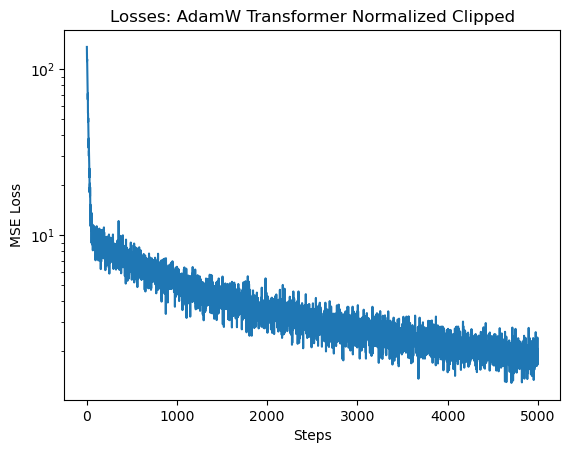

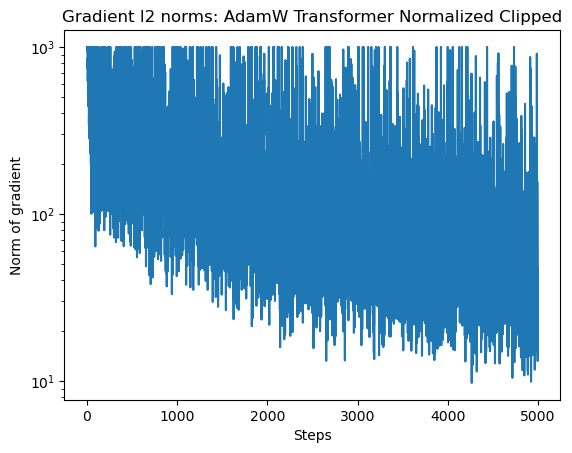

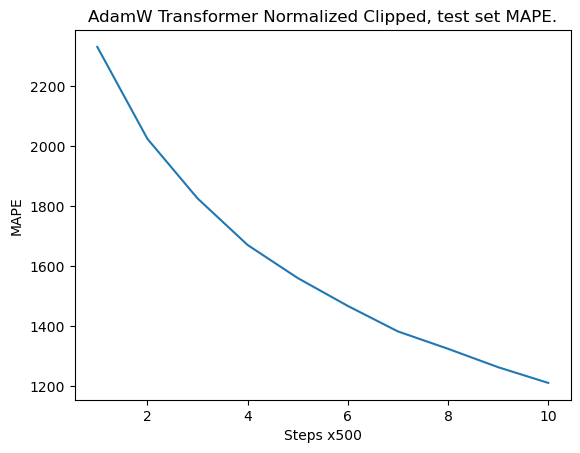

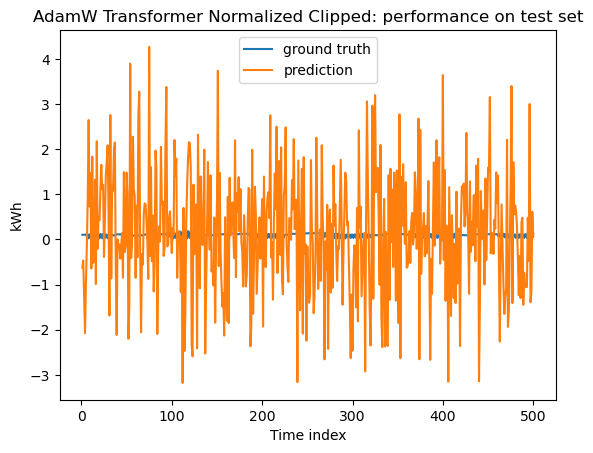

In [ ]:
# o, p = train_and_test(
#     'Transformer', # pass as the name containe in a string
#     lstm_model_kwargs,
#     'torch.optim.SGD', # pass as the name containe in a string
#     {'lr': 5e-5},
#     'SGD Transformer Normalized Clipped BigBatch',
#     True,
#     steps=5000,
#     BS=32,
#     clip_grad=1e+3
# )

On experiment AdamW Transformer Normalized Clipped BS256, step 501, loss is 6.363896369934082.: : 501it [01:03,  2.01s/it] 

On step 500, MAPE error is 2322.786383195357 percent.


On experiment AdamW Transformer Normalized Clipped BS256, step 1001, loss is 5.235698699951172.: : 1001it [02:08,  2.21s/it]

On step 1000, MAPE error is 2018.3998107910156 percent.


On experiment AdamW Transformer Normalized Clipped BS256, step 1503, loss is 4.055188179016113.: : 1502it [03:05,  1.48s/it] 

On step 1500, MAPE error is 1817.2549681230025 percent.


On experiment AdamW Transformer Normalized Clipped BS256, step 2003, loss is 3.2994346618652344.: : 2002it [03:49,  1.49s/it]

On step 2000, MAPE error is 1661.237369884144 percent.


On experiment AdamW Transformer Normalized Clipped BS256, step 2503, loss is 3.1936519145965576.: : 2502it [04:33,  1.47s/it]

On step 2500, MAPE error is 1554.5223756269975 percent.


On experiment AdamW Transformer Normalized Clipped BS256, step 3003, loss is 2.8113796710968018.: : 3002it [05:17,  1.46s/it]

On step 3000, MAPE error is 1458.5887128656561 percent.


On experiment AdamW Transformer Normalized Clipped BS256, step 3503, loss is 2.4846439361572266.: : 3502it [06:01,  1.50s/it]

On step 3500, MAPE error is 1379.8827344721014 percent.


On experiment AdamW Transformer Normalized Clipped BS256, step 4003, loss is 2.3443994522094727.: : 4002it [06:46,  1.49s/it]

On step 4000, MAPE error is 1320.6571145491166 percent.


On experiment AdamW Transformer Normalized Clipped BS256, step 4503, loss is 1.869929552078247.: : 4502it [07:30,  1.47s/it] 

On step 4500, MAPE error is 1261.702485518022 percent.


On experiment AdamW Transformer Normalized Clipped BS256, step 5000, loss is 1.9407570362091064.: : 4999it [08:14, 10.10it/s]

On step 5000, MAPE error is 1203.9847113869407 percent.


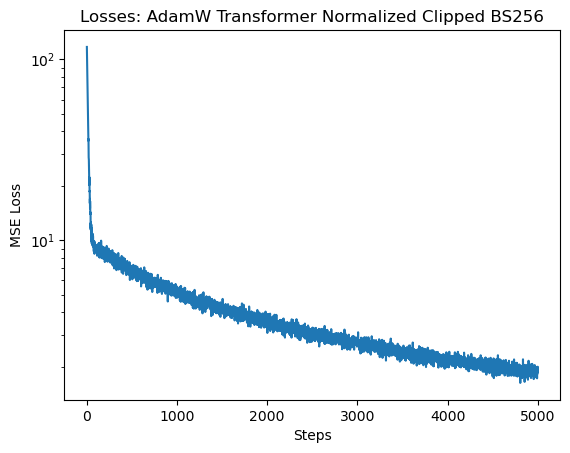

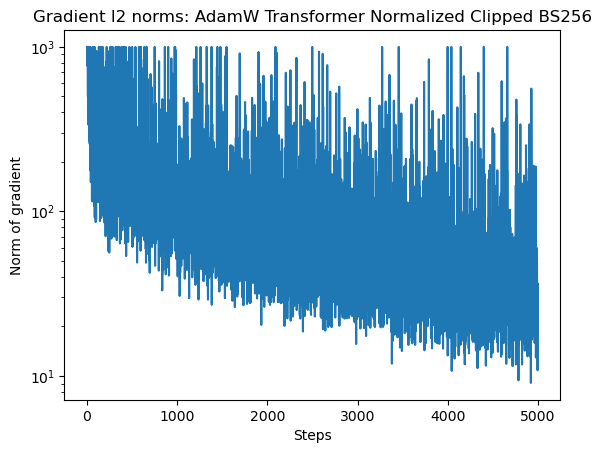

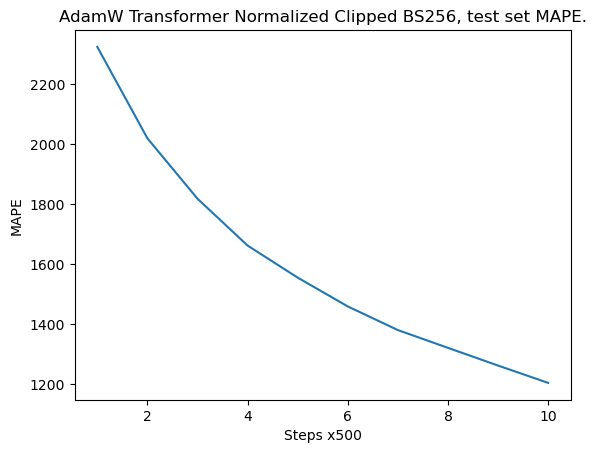

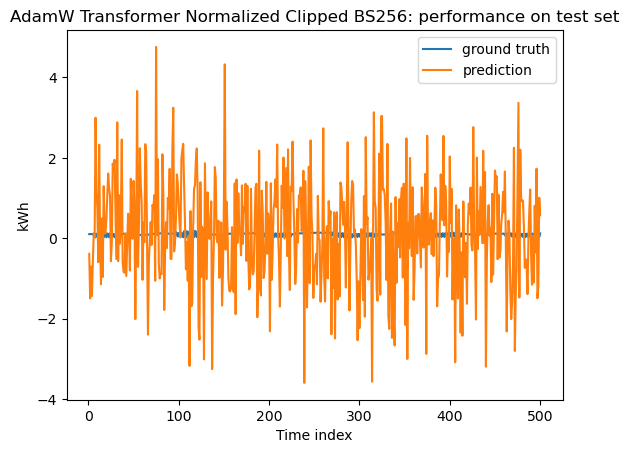

In [ ]:
o, p = train_and_test(
    'Transformer', # pass as the name containe in a string
    lstm_model_kwargs,
    'torch.optim.SGD', # pass as the name containe in a string
    {'lr': 5e-5},
    'SGD Transformer Normalized Clipped BS256',
    True,
    steps=5000,
    BS=256,
    clip_grad=1e+3
)

On experiment AdamW Transformer Normalized BS256 LongTrain, step 501, loss is 6.607041358947754.: : 501it [01:04,  2.26s/it] 

On step 500, MAPE error is 2355.7685158469462 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 1001, loss is 4.977931022644043.: : 1001it [02:10,  2.19s/it] 

On step 1000, MAPE error is 1920.7177769054067 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 1503, loss is 3.2432456016540527.: : 1502it [03:08,  1.53s/it]

On step 1500, MAPE error is 1638.8212550770152 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 2003, loss is 2.3148298263549805.: : 2002it [03:52,  1.53s/it]

On step 2000, MAPE error is 1416.4356578480113 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 2503, loss is 1.8872509002685547.: : 2502it [04:38,  1.52s/it]

On step 2500, MAPE error is 1235.84153435447 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 3003, loss is 1.554861068725586.: : 3002it [05:23,  1.52s/it] 

On step 3000, MAPE error is 1088.3806402033026 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 3503, loss is 1.1964977979660034.: : 3502it [06:07,  1.52s/it]

On step 3500, MAPE error is 960.9442190690474 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 4003, loss is 0.9333749413490295.: : 4002it [06:53,  1.51s/it]

On step 4000, MAPE error is 856.8503033031117 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 4501, loss is 0.7196643948554993.: : 4500it [07:38,  2.14s/it]

On step 4500, MAPE error is 764.3474015322598 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 5003, loss is 0.6232787370681763.: : 5002it [08:23,  1.53s/it]

On step 5000, MAPE error is 685.9364162791859 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 5503, loss is 0.5093044638633728.: : 5502it [09:08,  1.51s/it] 

On step 5500, MAPE error is 618.6546542427757 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 6003, loss is 0.3910137414932251.: : 6002it [09:53,  1.52s/it] 

On step 6000, MAPE error is 553.8802840492942 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 6503, loss is 0.34818220138549805.: : 6502it [10:38,  1.50s/it]

On step 6500, MAPE error is 499.85876083374023 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 7003, loss is 0.27714771032333374.: : 7002it [11:22,  1.50s/it]

On step 7000, MAPE error is 453.1022635373202 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 7503, loss is 0.2363128364086151.: : 7502it [12:09,  1.52s/it] 

On step 7500, MAPE error is 410.7321869243275 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 8003, loss is 0.17619892954826355.: : 8002it [12:54,  1.50s/it]

On step 8000, MAPE error is 374.5660890232433 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 8503, loss is 0.14345566928386688.: : 8502it [13:39,  1.51s/it]

On step 8500, MAPE error is 340.3558536009355 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 9003, loss is 0.13435763120651245.: : 9002it [14:24,  1.54s/it]

On step 9000, MAPE error is 312.3403614217585 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 9503, loss is 0.11256000399589539.: : 9502it [15:10,  1.50s/it]

On step 9500, MAPE error is 282.19163634560323 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 10000, loss is 0.08661586046218872.: : 9999it [15:54, 10.48it/s]

On step 10000, MAPE error is 261.2233552065763 percent.


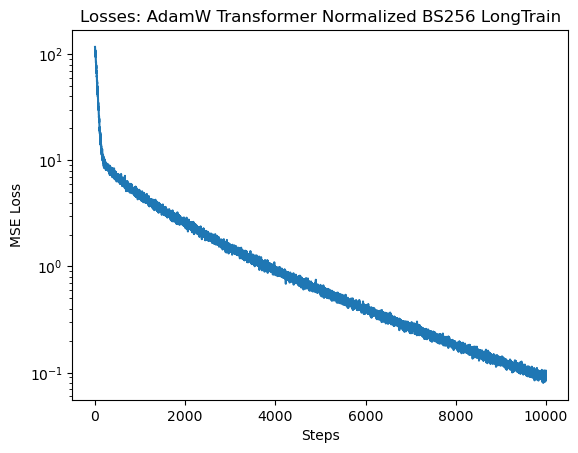

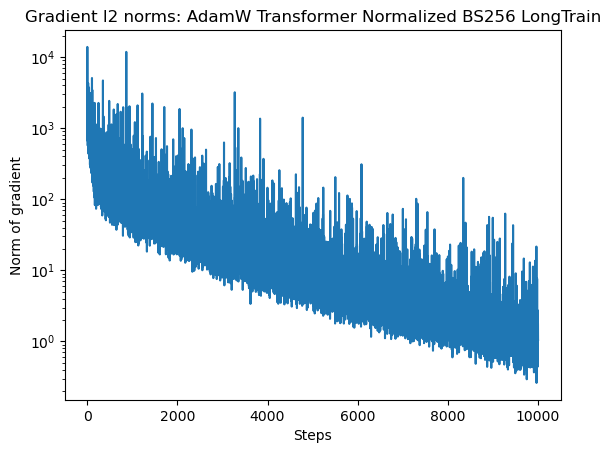

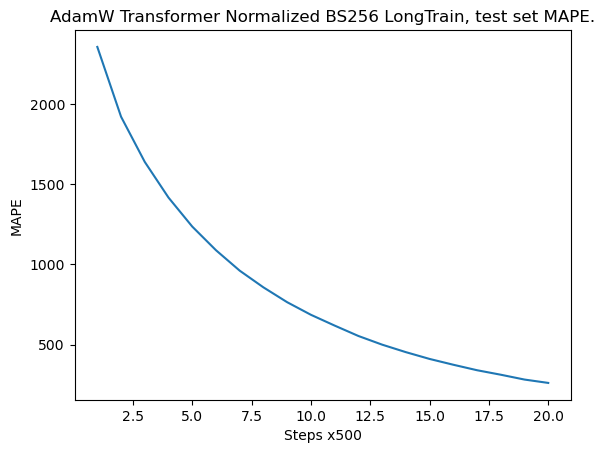

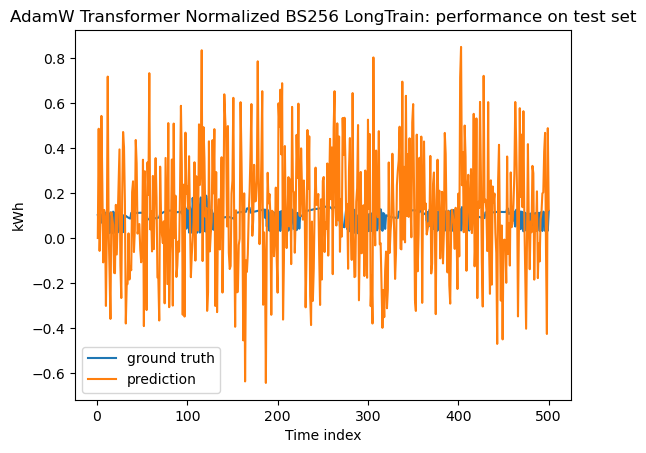

In [ ]:
o, p = train_and_test(
    'Transformer', # pass as the name containe in a string
    lstm_model_kwargs,
    'torch.optim.AdamW', # pass as the name containe in a string
    {'lr': 5e-5},
    'AdamW Transformer Normalized BS256 LongTrain',
    True,
    steps=10000,
    BS=256
)

On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 507, loss is 0.30115753412246704.: : 504it [00:26,  1.60it/s]

On step 500, MAPE error is 472.2070737318559 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 1007, loss is 0.16354379057884216.: : 1006it [00:52,  1.60it/s]

On step 1000, MAPE error is 359.53813249414617 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 1506, loss is 0.11700697243213654.: : 1504it [01:18,  1.60it/s]

On step 1500, MAPE error is 291.3129741495306 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 2008, loss is 0.08794756233692169.: : 2006it [01:44,  1.46it/s] 

On step 2000, MAPE error is 252.87100618535823 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 2508, loss is 0.0665748119354248.: : 2508it [02:10,  1.58it/s]  

On step 2500, MAPE error is 206.38472166928378 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 3007, loss is 0.05229334160685539.: : 3004it [02:35,  1.34it/s] 

On step 3000, MAPE error is 189.51865976507014 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 3507, loss is 0.030730528756976128.: : 3505it [03:02,  1.45it/s]

On step 3500, MAPE error is 166.19929508729413 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 4006, loss is 0.030660707503557205.: : 4004it [03:28,  1.40it/s]

On step 4000, MAPE error is 159.49675928462636 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 4507, loss is 0.036951594054698944.: : 4506it [03:55,  1.41it/s]

On step 4500, MAPE error is 144.76102482188833 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 5007, loss is 0.019127625972032547.: : 5006it [04:21,  1.62it/s]

On step 5000, MAPE error is 133.98490927436134 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 5507, loss is 0.031604960560798645.: : 5504it [04:46,  1.34it/s]

On step 5500, MAPE error is 132.5739329511469 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 6006, loss is 0.019087163731455803.: : 6006it [05:12,  1.59it/s]

On step 6000, MAPE error is 120.99921594966541 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 6508, loss is 0.018129071220755577.: : 6504it [05:38,  1.40it/s]

On step 6500, MAPE error is 116.13484079187566 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 7007, loss is 0.012958561070263386.: : 7005it [06:04,  1.37it/s]

On step 7000, MAPE error is 114.06893838535656 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 7507, loss is 0.011694238521158695.: : 7504it [06:29,  1.60it/s]

On step 7500, MAPE error is 116.44610600038008 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 8007, loss is 0.010008307173848152.: : 8004it [06:55,  1.38it/s]

On step 8000, MAPE error is 105.34699505025691 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 8506, loss is 0.0198748130351305.: : 8504it [07:21,  1.60it/s]  

On step 8500, MAPE error is 105.98075606606223 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 9007, loss is 0.01238952111452818.: : 9004it [07:47,  1.37it/s]  

On step 9000, MAPE error is 103.69583368301392 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 9507, loss is 0.01720738224685192.: : 9506it [08:13,  1.41it/s] 

On step 9500, MAPE error is 99.92338798262857 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 10007, loss is 0.013115538284182549.: : 10004it [08:39,  1.22it/s]

On step 10000, MAPE error is 99.31534962220626 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 10507, loss is 0.009342191740870476.: : 10505it [09:05,  1.63it/s] 

On step 10500, MAPE error is 94.23687349666248 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 11010, loss is 0.014127266593277454.: : 11006it [09:27,  1.86it/s] 

On step 11000, MAPE error is 94.12738247351213 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 11510, loss is 0.00887270923703909.: : 11510it [09:50,  2.07it/s]  

On step 11500, MAPE error is 93.799903717908 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 12009, loss is 0.01436562743037939.: : 12007it [10:13,  1.95it/s] 

On step 12000, MAPE error is 88.96641081029719 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 12511, loss is 0.013169795274734497.: : 12506it [10:36,  1.77it/s] 

On step 12500, MAPE error is 88.18200501528653 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 13010, loss is 0.00851929560303688.: : 13006it [10:58,  1.93it/s]  

On step 13000, MAPE error is 90.92398827726191 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 13510, loss is 0.008223457261919975.: : 13505it [11:22,  1.45it/s] 

On step 13500, MAPE error is 87.35044219277121 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 14010, loss is 0.007191137410700321.: : 14009it [11:45,  2.04it/s] 

On step 14000, MAPE error is 85.9385224905881 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 14510, loss is 0.010404849424958229.: : 14505it [12:08,  1.59it/s] 

On step 14500, MAPE error is 84.46463129737161 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 15009, loss is 0.015790358185768127.: : 15009it [12:30,  2.03it/s] 

On step 15000, MAPE error is 84.95199951258573 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 15509, loss is 0.009876726195216179.: : 15509it [12:54,  1.83it/s] 

On step 15500, MAPE error is 82.20169327475809 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 16010, loss is 0.011168351396918297.: : 16005it [13:17,  1.55it/s] 

On step 16000, MAPE error is 79.01821353218772 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 16510, loss is 0.013340618461370468.: : 16507it [13:40,  2.07it/s] 

On step 16500, MAPE error is 82.20016631213102 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 17009, loss is 0.007112445309758186.: : 17005it [14:03,  1.44it/s] 

On step 17000, MAPE error is 85.87815002961592 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 17509, loss is 0.009982094168663025.: : 17505it [14:26,  1.75it/s] 

On step 17500, MAPE error is 79.6055712483146 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 18011, loss is 0.010233751498162746.: : 18009it [14:49,  2.06it/s] 

On step 18000, MAPE error is 76.83804414489053 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 18509, loss is 0.0135969128459692.: : 18507it [15:11,  1.92it/s]   

On step 18500, MAPE error is 82.57909146222201 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 19008, loss is 0.007025125436484814.: : 19006it [15:35,  1.73it/s] 

On step 19000, MAPE error is 76.73666639761491 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 19510, loss is 0.007891057059168816.: : 19506it [15:58,  1.72it/s] 

On step 19500, MAPE error is 82.65373002399097 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 20000, loss is 0.011347400955855846.: : 19999it [16:20, 20.39it/s] 

On step 20000, MAPE error is 75.77094706622037 percent.


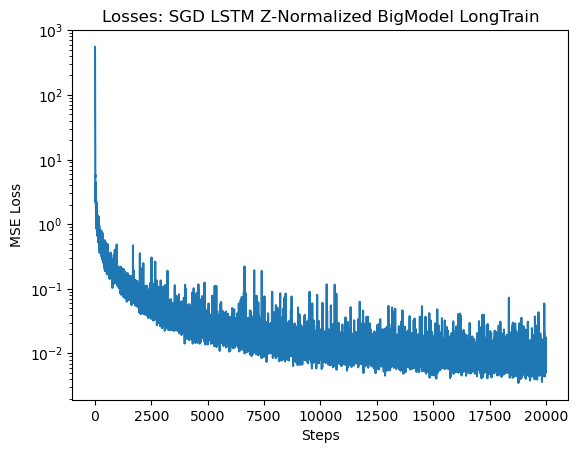

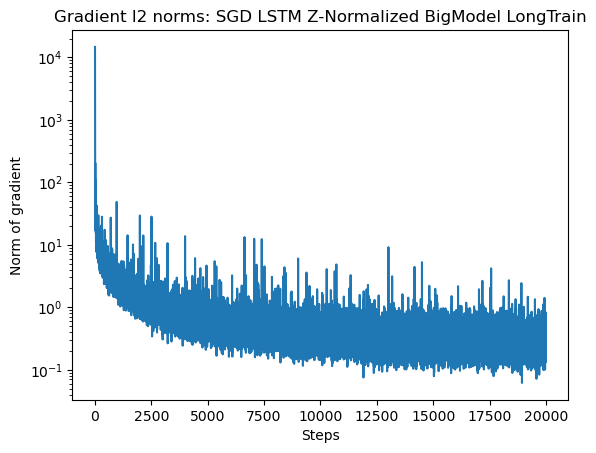

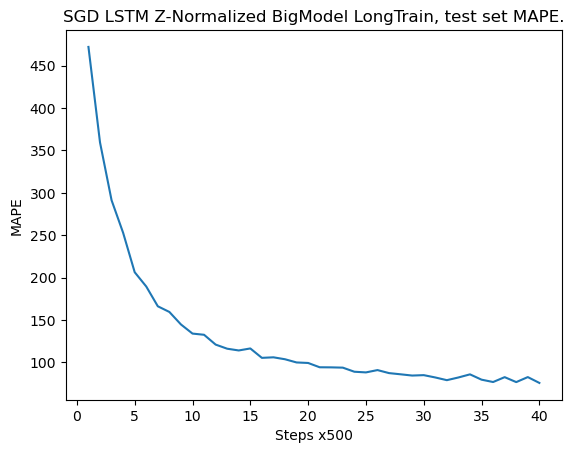

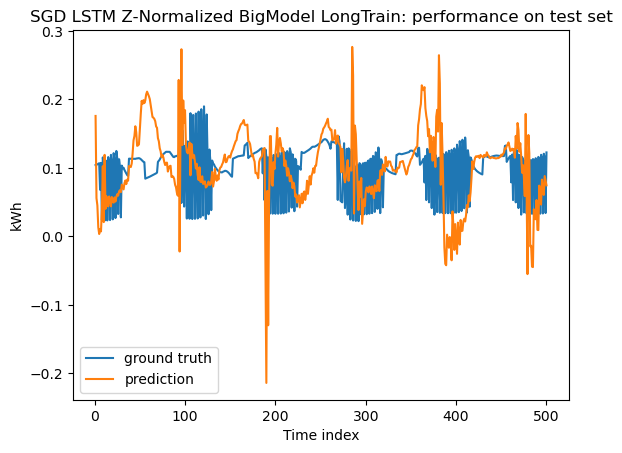

In [ ]:
# o,p = train_and_test(
#     'LSTMAR', # pass as the name containe in a string
#     lstm_model_kwargs,
#     'torch.optim.SGD', # pass as the name containe in a string
#     {'lr': 1e-3},
#     'SGD LSTM Z-Normalized BigModel LongTrain',
#     True,
#     steps=20000,
#     ntype='z'
# )

In [ ]:
# o, p = train_and_test(
#     'Transformer', # pass as the name containe in a string
#     lstm_model_kwargs,
#     'torch.optim.AdamW', # pass as the name containe in a string
#     {'lr': 5e-5},
#     'AdamW Transformer Normalized BS256 LongTrain',
#     True,
#     steps=30000,
#     BS=256,
#     ntype='z'
# )

On experiment AdamW Transformer Normalized BS256 LongTrain, step 502, loss is 6.7819623947143555.: : 502it [00:50,  1.54s/it]

On step 500, MAPE error is 2415.414151278409 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 1002, loss is 4.531991958618164.: : 1002it [01:41,  1.52s/it]

On step 1000, MAPE error is 1978.4772872924805 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 1506, loss is 3.5513968467712402.: : 1504it [02:24,  1.19it/s]

On step 1500, MAPE error is 1687.363797968084 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 2005, loss is 2.4247400760650635.: : 2003it [02:55,  1.01it/s]

On step 2000, MAPE error is 1454.7120874578302 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 2505, loss is 2.074286937713623.: : 2503it [03:25,  1.21it/s] 

On step 2500, MAPE error is 1267.299071225253 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 3005, loss is 1.6541417837142944.: : 3003it [03:56,  1.03it/s]

On step 3000, MAPE error is 1113.6734789068048 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 3506, loss is 1.2009150981903076.: : 3506it [04:27,  1.17it/s]

On step 3500, MAPE error is 984.2734857039018 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 4005, loss is 0.9562602639198303.: : 4003it [04:57,  1.23it/s]

On step 4000, MAPE error is 878.2409407875755 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 4505, loss is 0.7868919372558594.: : 4504it [05:28,  1.23it/s]

On step 4500, MAPE error is 784.8573511297053 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 5006, loss is 0.6263433694839478.: : 5005it [05:58,  1.23it/s]

On step 5000, MAPE error is 701.2231783433394 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 5506, loss is 0.4893478453159332.: : 5505it [06:29,  1.28it/s] 

On step 5500, MAPE error is 633.6398168043656 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 6006, loss is 0.38286006450653076.: : 6004it [07:00,  1.16it/s]

On step 6000, MAPE error is 569.3279006264427 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 6505, loss is 0.32823827862739563.: : 6505it [07:30,  1.21it/s]

On step 6500, MAPE error is 513.3619351820512 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 7006, loss is 0.2532705068588257.: : 7003it [08:01,  1.08s/it] 

On step 7000, MAPE error is 463.7420437552712 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 7504, loss is 0.23623353242874146.: : 7503it [08:31,  1.09s/it]

On step 7500, MAPE error is 421.5904235839844 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 8005, loss is 0.18072545528411865.: : 8005it [09:01,  1.23it/s]

On step 8000, MAPE error is 383.3448128266768 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 8505, loss is 0.1582135260105133.: : 8503it [09:31,  1.22it/s] 

On step 8500, MAPE error is 348.68613806637853 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 9005, loss is 0.1176803857088089.: : 9004it [10:01,  1.23it/s] 

On step 9000, MAPE error is 318.0605714971369 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 9504, loss is 0.0964994877576828.: : 9503it [10:32,  1.23it/s] 

On step 9500, MAPE error is 292.2485091469505 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 10005, loss is 0.08958877623081207.: : 10004it [11:02,  1.32it/s]

On step 10000, MAPE error is 266.3521723313765 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 10506, loss is 0.069158636033535.: : 10506it [11:32,  1.31it/s]  

On step 10500, MAPE error is 246.08745358207008 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 11004, loss is 0.06430371105670929.: : 11002it [12:03,  1.06s/it] 

On step 11000, MAPE error is 224.0917747670954 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 11505, loss is 0.05863261595368385.: : 11503it [12:33,  1.07it/s] 

On step 11500, MAPE error is 208.5699731653387 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 12005, loss is 0.0457935705780983.: : 12003it [13:04,  1.01it/s]  

On step 12000, MAPE error is 194.05451146039096 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 12505, loss is 0.04095609486103058.: : 12503it [13:35,  1.02s/it] 

On step 12500, MAPE error is 178.0913082036105 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 13006, loss is 0.036615438759326935.: : 13003it [14:05,  1.21it/s]

On step 13000, MAPE error is 167.56721193140203 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 13505, loss is 0.03189702704548836.: : 13503it [14:36,  1.04s/it] 

On step 13500, MAPE error is 156.3849698413502 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 14006, loss is 0.028158755972981453.: : 14004it [15:06,  1.31it/s]

On step 14000, MAPE error is 149.3721062486822 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 14505, loss is 0.02948315627872944.: : 14503it [15:37,  1.07s/it] 

On step 14500, MAPE error is 138.02739598534325 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 15005, loss is 0.026757895946502686.: : 15003it [16:08,  1.22it/s]

On step 15000, MAPE error is 130.13314333829013 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 15504, loss is 0.025666318833827972.: : 15503it [16:39,  1.19it/s]

On step 15500, MAPE error is 125.73958201841874 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 16006, loss is 0.018728742375969887.: : 16006it [17:10,  1.11it/s]

On step 16000, MAPE error is 119.75983814759688 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 16506, loss is 0.021871434524655342.: : 16505it [17:40,  1.31it/s]

On step 16500, MAPE error is 114.37818245454268 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 17006, loss is 0.019853025674819946.: : 17004it [18:11,  1.30it/s]

On step 17000, MAPE error is 113.6828606778925 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 17505, loss is 0.015763428062200546.: : 17503it [18:42,  1.11it/s]

On step 17500, MAPE error is 106.96843645789407 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 17657, loss is 0.014143962413072586.: : 17657it [18:47, 15.66it/s]


KeyboardInterrupt: 

On experiment SGD Transformer Normalized BS256 LongTrain, step 502, loss is 6.587104797363281.: : 502it [00:50,  1.52s/it] 

On step 500, MAPE error is 2360.8766382390804 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 1002, loss is 4.870180130004883.: : 1002it [01:39,  1.53s/it] 

On step 1000, MAPE error is 2050.8247722278943 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 1506, loss is 4.196661472320557.: : 1504it [02:22,  1.19it/s] 

On step 1500, MAPE error is 1850.7489117709074 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 2006, loss is 3.693204402923584.: : 2003it [02:51,  1.23it/s] 

On step 2000, MAPE error is 1694.5864070545542 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 2505, loss is 2.9718716144561768.: : 2503it [03:21,  1.01s/it]

On step 2500, MAPE error is 1572.514768080278 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 3007, loss is 2.717578649520874.: : 3004it [03:50,  1.01it/s] 

On step 3000, MAPE error is 1480.8139540932395 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 3505, loss is 2.622089385986328.: : 3504it [04:20,  1.30it/s] 

On step 3500, MAPE error is 1407.6617154208097 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 4006, loss is 2.12662935256958.: : 4004it [04:49,  1.31it/s]  

On step 4000, MAPE error is 1342.1051718971946 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 4506, loss is 1.9922194480895996.: : 4503it [05:18,  1.06s/it]

On step 4500, MAPE error is 1278.9268580350008 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 5006, loss is 1.9826608896255493.: : 5006it [05:47,  1.32it/s]

On step 5000, MAPE error is 1229.3598608537154 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 5506, loss is 1.6732453107833862.: : 5504it [06:16,  1.23it/s]

On step 5500, MAPE error is 1184.8260879516602 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 6007, loss is 1.681337833404541.: : 6005it [06:46,  1.33it/s] 

On step 6000, MAPE error is 1145.726099881259 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 6506, loss is 1.5386364459991455.: : 6504it [07:15,  1.33it/s]

On step 6500, MAPE error is 1110.95890565352 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 7006, loss is 1.4283435344696045.: : 7003it [07:44,  1.09s/it]

On step 7000, MAPE error is 1080.7856559753418 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 7506, loss is 1.2849664688110352.: : 7504it [08:14,  1.20it/s]

On step 7500, MAPE error is 1054.6845089305532 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 8006, loss is 1.172208547592163.: : 8006it [08:44,  1.19it/s] 

On step 8000, MAPE error is 1023.1946251609108 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 8505, loss is 1.2424838542938232.: : 8503it [09:13,  1.08it/s]

On step 8500, MAPE error is 998.5601858659224 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 9006, loss is 1.125868320465088.: : 9004it [09:43,  1.13it/s] 

On step 9000, MAPE error is 980.0301725214177 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 9505, loss is 1.1538044214248657.: : 9504it [10:12,  1.19it/s]

On step 9500, MAPE error is 954.9766713922673 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 10006, loss is 1.0274779796600342.: : 10003it [10:41,  1.10it/s]

On step 10000, MAPE error is 937.4458833174272 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 10505, loss is 1.0397558212280273.: : 10504it [11:11,  1.19it/s]

On step 10500, MAPE error is 915.4369180852717 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 11005, loss is 1.0070382356643677.: : 11003it [11:40,  1.23it/s]

On step 11000, MAPE error is 898.9611799066716 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 11506, loss is 0.9236854314804077.: : 11503it [12:10,  1.08it/s]

On step 11500, MAPE error is 882.6515024358577 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 12005, loss is 0.9287450909614563.: : 12005it [12:39,  1.22it/s]

On step 12000, MAPE error is 867.9784254594283 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 12504, loss is 0.9115585088729858.: : 12502it [13:08,  1.08s/it]

On step 12500, MAPE error is 853.4407789056951 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 13005, loss is 0.8826591372489929.: : 13003it [13:38,  1.08s/it]

On step 13000, MAPE error is 836.9339249350808 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 13505, loss is 0.8123006820678711.: : 13503it [14:07,  1.23it/s]

On step 13500, MAPE error is 824.9682859940963 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 14006, loss is 0.7918781638145447.: : 14006it [14:36,  1.34it/s]

On step 14000, MAPE error is 815.2457237243652 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 14506, loss is 0.7189203500747681.: : 14505it [15:06,  1.33it/s]

On step 14500, MAPE error is 800.3498987718062 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 15007, loss is 0.8128768801689148.: : 15006it [15:35,  1.34it/s]

On step 15000, MAPE error is 790.5721751126376 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 15506, loss is 0.7121995687484741.: : 15503it [16:04,  1.06s/it]

On step 15500, MAPE error is 775.3317356109619 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 16005, loss is 0.7408859729766846.: : 16003it [16:34,  1.14it/s]

On step 16000, MAPE error is 767.7615295756947 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 16506, loss is 0.703126072883606.: : 16504it [17:03,  1.11it/s] 

On step 16500, MAPE error is 757.3578877882524 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 17006, loss is 0.6349555253982544.: : 17004it [17:33,  1.19it/s]

On step 17000, MAPE error is 747.2805023193359 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 17507, loss is 0.6766514778137207.: : 17504it [18:02,  1.31it/s]

On step 17500, MAPE error is 736.8413318287243 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 18007, loss is 0.6483707427978516.: : 18004it [18:31,  1.33it/s]

On step 18000, MAPE error is 726.9065553491765 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 18505, loss is 0.6128454804420471.: : 18503it [19:00,  1.24it/s]

On step 18500, MAPE error is 718.7421148473567 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 19006, loss is 0.604981541633606.: : 19003it [19:29,  1.06s/it] 

On step 19000, MAPE error is 710.2400562979958 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 19505, loss is 0.5728572010993958.: : 19504it [19:59,  1.31it/s]

On step 19500, MAPE error is 697.4465370178223 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 20006, loss is 0.5815463662147522.: : 20006it [20:28,  1.34it/s]

On step 20000, MAPE error is 692.4105340784246 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 20506, loss is 0.5796830058097839.: : 20503it [20:58,  1.08s/it]

On step 20500, MAPE error is 686.1604127016934 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 21006, loss is 0.5145382881164551.: : 21005it [21:27,  1.31it/s] 

On step 21000, MAPE error is 681.2172759662975 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 21505, loss is 0.5465037226676941.: : 21503it [21:57,  1.08s/it] 

On step 21500, MAPE error is 670.5626487731934 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 22007, loss is 0.5006582140922546.: : 22006it [22:26,  1.30it/s] 

On step 22000, MAPE error is 663.7646154923873 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 22505, loss is 0.5451158881187439.: : 22503it [22:56,  1.13it/s] 

On step 22500, MAPE error is 658.5778886621648 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 23007, loss is 0.5420852303504944.: : 23006it [23:25,  1.33it/s] 

On step 23000, MAPE error is 651.7807657068425 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 23506, loss is 0.5333914756774902.: : 23505it [23:54,  1.33it/s] 

On step 23500, MAPE error is 644.6703650734642 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 24006, loss is 0.4911247491836548.: : 24003it [24:24,  1.06s/it] 

On step 24000, MAPE error is 637.4278285286643 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 24506, loss is 0.5140074491500854.: : 24504it [24:53,  1.26it/s] 

On step 24500, MAPE error is 632.4116836894642 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 25007, loss is 0.5038981437683105.: : 25004it [25:22,  1.33it/s] 

On step 25000, MAPE error is 625.3520835529674 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 25505, loss is 0.4788562059402466.: : 25504it [25:52,  1.31it/s] 

On step 25500, MAPE error is 617.9339625618675 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 26006, loss is 0.4818480610847473.: : 26004it [26:21,  1.31it/s] 

On step 26000, MAPE error is 613.6510155417702 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 26505, loss is 0.4514473080635071.: : 26503it [26:50,  1.24it/s] 

On step 26500, MAPE error is 607.78357332403 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 27006, loss is 0.47188276052474976.: : 27004it [27:20,  1.19it/s]

On step 27000, MAPE error is 601.4224442568692 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 27506, loss is 0.41081374883651733.: : 27505it [27:49,  1.23it/s]

On step 27500, MAPE error is 599.198935248635 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 28004, loss is 0.4177781939506531.: : 28003it [28:19,  1.13it/s] 

On step 28000, MAPE error is 593.6704895713112 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 28506, loss is 0.41151490807533264.: : 28506it [28:48,  1.32it/s]

On step 28500, MAPE error is 590.9523010253906 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 29006, loss is 0.4448889493942261.: : 29006it [29:18,  1.31it/s] 

On step 29000, MAPE error is 584.3144633553245 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 29505, loss is 0.40714389085769653.: : 29503it [29:47,  1.21it/s]

On step 29500, MAPE error is 581.7408518357711 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 30000, loss is 0.4454934597015381.: : 29999it [30:17, 16.51it/s] 

On step 30000, MAPE error is 575.6223461844704 percent.


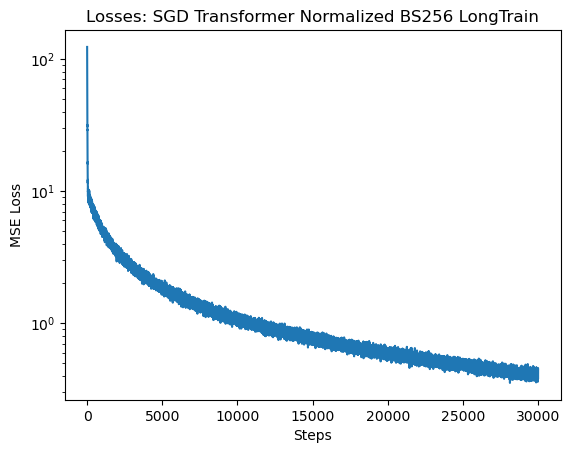

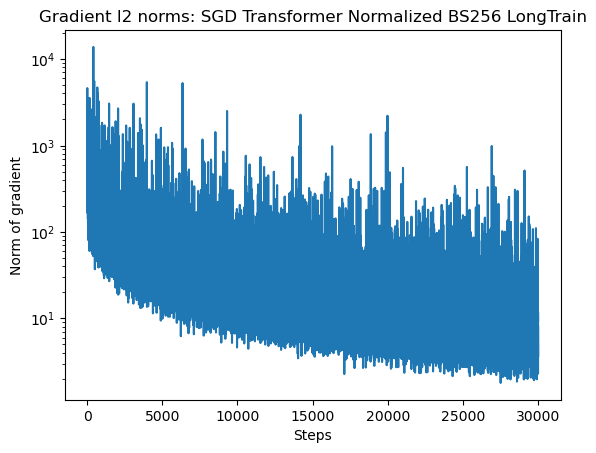

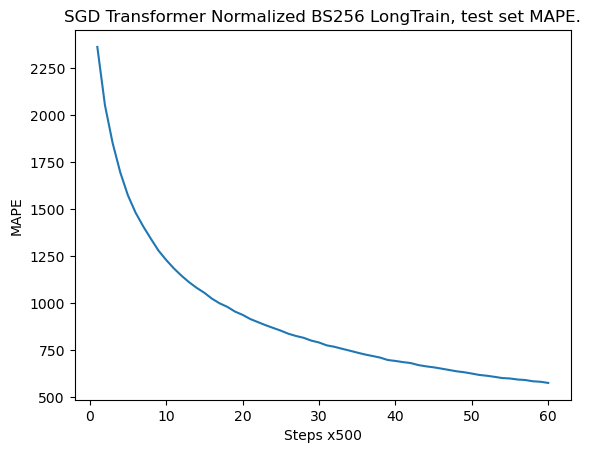

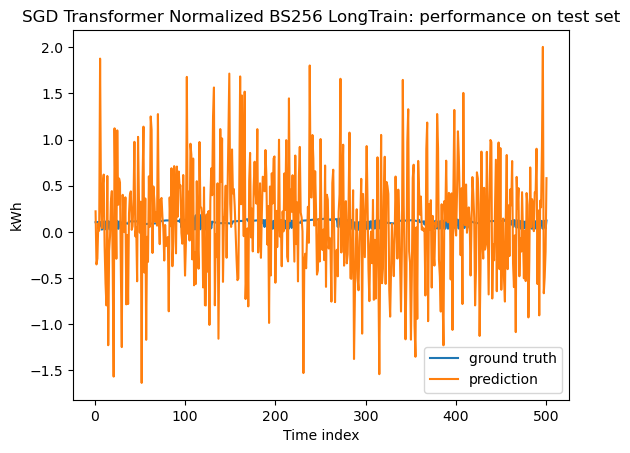

In [ ]:
# o, p = train_and_test(
#     'Transformer', # pass as the name containe in a string
#     lstm_model_kwargs,
#     'torch.optim.SGD', # pass as the name containe in a string
#     {'lr': 5e-5},
#     'SGD Transformer Normalized BS256 LongTrain',
#     True,
#     steps=30000,
#     BS=256,
#     ntype='z'
# )

On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 511, loss is 1.371086835861206.: : 506it [00:22,  1.76it/s] 

On step 500, MAPE error is 93.66994987834583 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 1011, loss is 2.817460775375366.: : 1010it [00:44,  2.08it/s] 

On step 1000, MAPE error is 76.18517496369101 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 1511, loss is 0.948694109916687.: : 1508it [01:05,  2.11it/s]  

On step 1500, MAPE error is 73.71730316768993 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 2011, loss is 0.7333134412765503.: : 2006it [01:27,  2.12it/s] 

On step 2000, MAPE error is 65.16827724196695 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 2511, loss is 0.5917776823043823.: : 2510it [01:49,  2.08it/s] 

On step 2500, MAPE error is 68.70364221659574 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 3011, loss is 0.6229427456855774.: : 3006it [02:10,  1.98it/s] 

On step 3000, MAPE error is 60.318516059355304 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 3511, loss is 0.7451375126838684.: : 3506it [02:32,  1.89it/s] 

On step 3500, MAPE error is 59.92148572748358 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 4011, loss is 1.0863242149353027.: : 4010it [02:54,  2.09it/s] 

On step 4000, MAPE error is 60.16816334290938 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 4511, loss is 0.6750256419181824.: : 4508it [03:16,  2.11it/s] 

On step 4500, MAPE error is 58.516258001327515 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 5011, loss is 0.6791036128997803.: : 5011it [03:38,  2.12it/s] 

On step 5000, MAPE error is 56.09611056067727 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 5511, loss is 0.44515204429626465.: : 5509it [03:59,  2.09it/s]

On step 5500, MAPE error is 57.81358751383695 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 6011, loss is 0.5294485092163086.: : 6006it [04:21,  2.04it/s] 

On step 6000, MAPE error is 54.448892853476785 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 6511, loss is 0.38748791813850403.: : 6506it [04:43,  1.88it/s]

On step 6500, MAPE error is 54.64148846539584 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 7011, loss is 0.9533465504646301.: : 7010it [05:04,  2.08it/s] 

On step 7000, MAPE error is 54.52626510099931 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 7511, loss is 0.38370561599731445.: : 7508it [05:26,  2.11it/s]

On step 7500, MAPE error is 53.761620955033735 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 8011, loss is 0.825122594833374.: : 8006it [05:48,  2.07it/s]  

On step 8000, MAPE error is 53.67673256180503 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 8511, loss is 0.5716781616210938.: : 8506it [06:10,  1.80it/s] 

On step 8500, MAPE error is 56.00727200508118 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 9011, loss is 0.3582732081413269.: : 9006it [06:32,  1.82it/s] 

On step 9000, MAPE error is 54.48790734464472 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 9511, loss is 0.9281904697418213.: : 9510it [06:54,  2.07it/s] 

On step 9500, MAPE error is 53.54507944800637 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 10011, loss is 0.38437145948410034.: : 10008it [07:16,  2.08it/s]

On step 10000, MAPE error is 50.696248899806626 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 10507, loss is 0.37124231457710266.: : 10506it [07:38,  2.12it/s]

On step 10500, MAPE error is 54.62861982258883 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 11016, loss is 0.5443626642227173.: : 11015it [07:57,  3.13it/s] 

On step 11000, MAPE error is 55.69034543904391 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 11516, loss is 0.4088851511478424.: : 11510it [08:16,  3.17it/s] 

On step 11500, MAPE error is 55.83955483003096 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 12015, loss is 0.30911335349082947.: : 12008it [08:36,  3.04it/s]

On step 12000, MAPE error is 57.00697682120583 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 12516, loss is 0.40003663301467896.: : 12512it [08:55,  3.12it/s]

On step 12500, MAPE error is 53.132858059623025 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 13016, loss is 0.47291624546051025.: : 13016it [09:14,  3.16it/s]

On step 13000, MAPE error is 55.0269755450162 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 13516, loss is 0.5471805334091187.: : 13516it [09:33,  3.06it/s] 

On step 13500, MAPE error is 50.676943497224286 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 14016, loss is 0.3861417770385742.: : 14009it [09:52,  2.99it/s] 

On step 14000, MAPE error is 51.63578662005338 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 14516, loss is 0.5054028630256653.: : 14509it [10:12,  2.58it/s] 

On step 14500, MAPE error is 49.67386695471677 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 15012, loss is 0.3265872299671173.: : 15009it [10:31,  2.87it/s] 

On step 15000, MAPE error is 52.71144617687572 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 15516, loss is 0.5488391518592834.: : 15509it [10:50,  2.81it/s] 

On step 15500, MAPE error is 51.14269066940654 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 16016, loss is 0.35756009817123413.: : 16013it [11:09,  3.11it/s]

On step 16000, MAPE error is 50.32912763682279 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 16516, loss is 0.4591967463493347.: : 16508it [11:28,  2.24it/s] 

On step 16500, MAPE error is 52.31890624219721 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 17016, loss is 0.41163307428359985.: : 17012it [11:48,  3.13it/s]

On step 17000, MAPE error is 51.272232424129136 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 17516, loss is 0.5916105508804321.: : 17516it [12:07,  3.15it/s] 

On step 17500, MAPE error is 51.30831761793657 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 18016, loss is 0.3805171847343445.: : 18010it [12:26,  3.02it/s] 

On step 18000, MAPE error is 48.88680252161893 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 18516, loss is 0.4610568583011627.: : 18514it [12:45,  3.16it/s] 

On step 18500, MAPE error is 51.19187642227519 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 19015, loss is 0.30152204632759094.: : 19013it [13:04,  3.07it/s]

On step 19000, MAPE error is 50.61608309095556 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 19516, loss is 0.4482516646385193.: : 19509it [13:24,  2.98it/s] 

On step 19500, MAPE error is 53.53156436573375 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 20015, loss is 0.39209362864494324.: : 20013it [13:43,  2.84it/s]

On step 20000, MAPE error is 50.811905752528794 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 20516, loss is 0.3136281371116638.: : 20509it [14:03,  2.91it/s] 

On step 20500, MAPE error is 48.46062633124265 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 21016, loss is 0.611085057258606.: : 21009it [14:22,  2.71it/s]  

On step 21000, MAPE error is 50.95250606536865 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 21515, loss is 0.3933815360069275.: : 21508it [14:41,  3.03it/s] 

On step 21500, MAPE error is 50.123753872784704 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 22015, loss is 0.3944171667098999.: : 22008it [15:01,  3.01it/s] 

On step 22000, MAPE error is 50.938511707566 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 22516, loss is 0.3928304612636566.: : 22509it [15:20,  3.16it/s] 

On step 22500, MAPE error is 50.363805348222904 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 23016, loss is 0.47055482864379883.: : 23011it [15:39,  2.90it/s]

On step 23000, MAPE error is 50.107961622151464 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 23516, loss is 0.7425989508628845.: : 23514it [15:58,  3.15it/s] 

On step 23500, MAPE error is 48.215311494740575 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 24016, loss is 0.3385758101940155.: : 24016it [16:18,  3.12it/s] 

On step 24000, MAPE error is 47.78414477001537 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 24517, loss is 0.3789217472076416.: : 24511it [16:37,  3.14it/s] 

On step 24500, MAPE error is 49.846184795553036 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 25016, loss is 0.48453083634376526.: : 25013it [16:56,  3.17it/s]

On step 25000, MAPE error is 48.70741882107475 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 25516, loss is 0.5860282778739929.: : 25508it [17:15,  2.21it/s] 

On step 25500, MAPE error is 48.034218766472556 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 26016, loss is 0.5636711716651917.: : 26012it [17:34,  3.16it/s] 

On step 26000, MAPE error is 47.34821373766119 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 26516, loss is 0.38578805327415466.: : 26516it [17:53,  3.10it/s]

On step 26500, MAPE error is 50.629279288378626 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 27016, loss is 0.2947462201118469.: : 27009it [18:12,  3.01it/s] 

On step 27000, MAPE error is 52.41274454376914 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 27517, loss is 0.36706769466400146.: : 27509it [18:32,  3.02it/s]

On step 27500, MAPE error is 47.493477572094314 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 28016, loss is 0.4522114396095276.: : 28008it [18:51,  2.75it/s] 

On step 28000, MAPE error is 47.89263308048248 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 28515, loss is 0.3428751826286316.: : 28508it [19:10,  2.82it/s] 

On step 28500, MAPE error is 51.52536793188615 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 29015, loss is 0.6839123964309692.: : 29008it [19:29,  3.00it/s] 

On step 29000, MAPE error is 45.543888482180506 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 29515, loss is 0.3287544548511505.: : 29508it [19:49,  3.05it/s] 

On step 29500, MAPE error is 47.76381660591472 percent.


On experiment SGD LSTM Z-Normalized BigModel LongTrain, step 30000, loss is 0.47390568256378174.: : 29999it [20:08, 24.82it/s]

On step 30000, MAPE error is 46.59591696479104 percent.


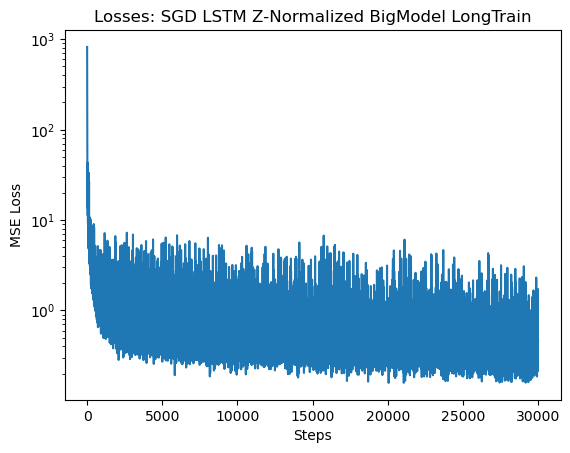

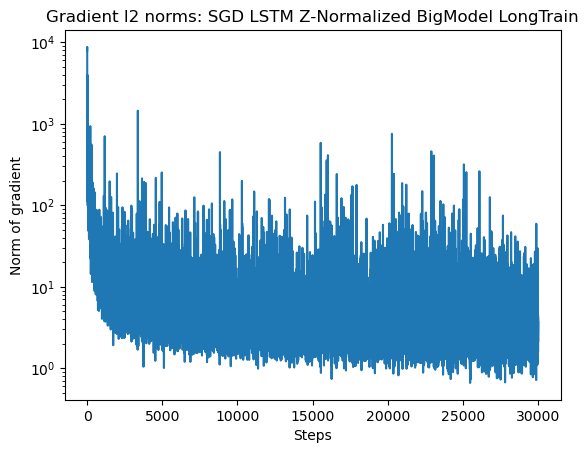

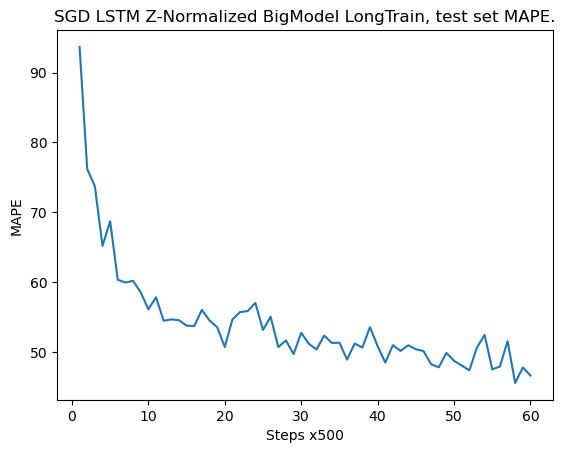

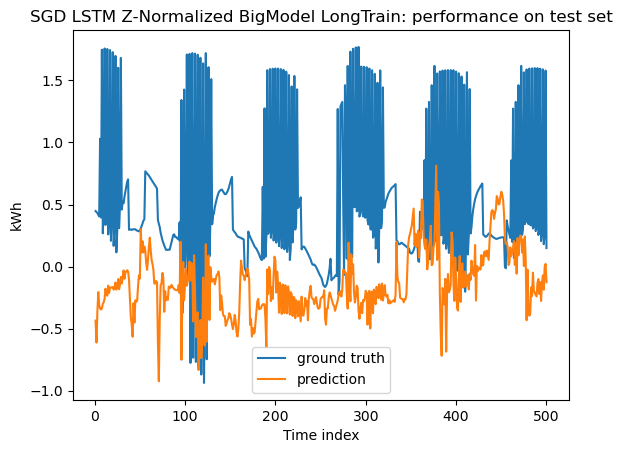

In [ ]:
o,p = train_and_test(
    'LSTMAR', # pass as the name containe in a string
    lstm_model_kwargs,
    'torch.optim.SGD', # pass as the name containe in a string
    {'lr': 1e-3},
    'SGD LSTM Z-Normalized BigModel LongTrain',
    True,
    steps=30000,
    ntype='z'
)

On experiment SGD Transformer Normalized BS256 LongTrain, step 502, loss is 7.230926513671875.: : 502it [00:50,  1.66s/it] 

On step 500, MAPE error is 200.71262229572642 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 1002, loss is 5.783289432525635.: : 1001it [01:39,  1.77s/it]

On step 1000, MAPE error is 176.6855077310042 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 1507, loss is 5.3692522048950195.: : 1504it [02:21,  1.29it/s]

On step 1500, MAPE error is 161.6359829902649 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 2006, loss is 5.153814315795898.: : 2004it [02:49,  1.14it/s] 

On step 2000, MAPE error is 149.83702898025513 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 2506, loss is 3.808445930480957.: : 2504it [03:18,  1.34it/s] 

On step 2500, MAPE error is 141.2555759603327 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 3006, loss is 3.6583855152130127.: : 3006it [03:47,  1.34it/s]

On step 3000, MAPE error is 134.1280460357666 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 3506, loss is 3.439183473587036.: : 3506it [04:15,  1.33it/s] 

On step 3500, MAPE error is 128.74531637538564 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 4006, loss is 3.1016266345977783.: : 4006it [04:43,  1.36it/s]

On step 4000, MAPE error is 124.13727695291692 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 4507, loss is 3.1662354469299316.: : 4504it [05:11,  1.29it/s]

On step 4500, MAPE error is 119.2822976545854 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 5006, loss is 2.5343713760375977.: : 5003it [05:40,  1.14it/s]

On step 5000, MAPE error is 116.0746769471602 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 5507, loss is 2.566134452819824.: : 5503it [06:09,  1.11s/it] 

On step 5500, MAPE error is 112.90260336615823 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 6006, loss is 2.3922972679138184.: : 6006it [06:37,  1.34it/s]

On step 6000, MAPE error is 110.08205197074197 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 6505, loss is 2.608346939086914.: : 6505it [07:05,  1.23it/s] 

On step 6500, MAPE error is 108.07223428379406 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 7005, loss is 2.203335762023926.: : 7004it [07:34,  1.24it/s] 

On step 7000, MAPE error is 105.75893683867021 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 7507, loss is 1.785459280014038.: : 7504it [08:02,  1.36it/s] 

On step 7500, MAPE error is 104.06674471768466 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 8006, loss is 2.145632743835449.: : 8003it [08:31,  1.03s/it] 

On step 8000, MAPE error is 102.19078389081088 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 8505, loss is 2.502716064453125.: : 8503it [08:59,  1.12it/s] 

On step 8500, MAPE error is 100.83034146915783 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 9006, loss is 2.2511467933654785.: : 9006it [09:28,  1.35it/s]

On step 9000, MAPE error is 98.953378200531 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 9507, loss is 1.8082208633422852.: : 9506it [09:56,  1.33it/s]

On step 9500, MAPE error is 97.5490391254425 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 10007, loss is 1.8924782276153564.: : 10004it [10:25,  1.34it/s]

On step 10000, MAPE error is 96.44674387845126 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 10507, loss is 1.898503303527832.: : 10506it [10:54,  1.33it/s] 

On step 10500, MAPE error is 95.12493231079794 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 11006, loss is 1.8220367431640625.: : 11004it [11:22,  1.23it/s]

On step 11000, MAPE error is 93.14426563002847 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 11505, loss is 2.2878918647766113.: : 11504it [11:50,  1.21it/s]

On step 11500, MAPE error is 92.72445440292358 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 12006, loss is 2.2559518814086914.: : 12004it [12:19,  1.34it/s]

On step 12000, MAPE error is 92.34873760830273 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 12506, loss is 2.109499931335449.: : 12504it [12:47,  1.28it/s] 

On step 12500, MAPE error is 91.04675162922253 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 13005, loss is 1.6595207452774048.: : 13005it [13:16,  1.24it/s]

On step 13000, MAPE error is 90.17233415083452 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 13507, loss is 1.3488070964813232.: : 13505it [13:45,  1.34it/s]

On step 13500, MAPE error is 89.15954178029841 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 14006, loss is 1.7764064073562622.: : 14006it [14:13,  1.36it/s]

On step 14000, MAPE error is 88.87540914795615 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 14507, loss is 1.8684215545654297.: : 14504it [14:41,  1.29it/s]

On step 14500, MAPE error is 88.28679865056819 percent.


On experiment SGD Transformer Normalized BS256 LongTrain, step 15000, loss is 1.496260404586792.: : 14999it [15:10, 16.48it/s] 

On step 15000, MAPE error is 87.11303635077043 percent.


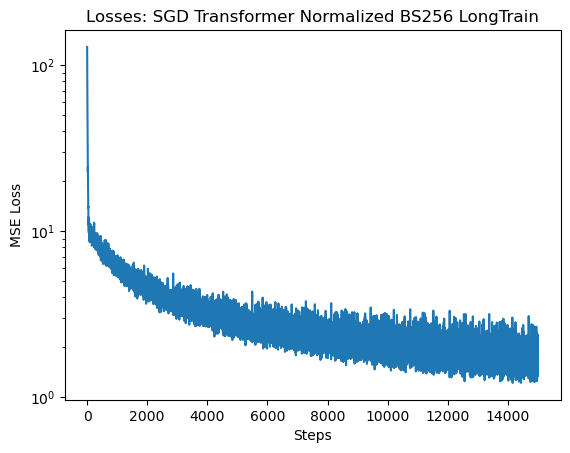

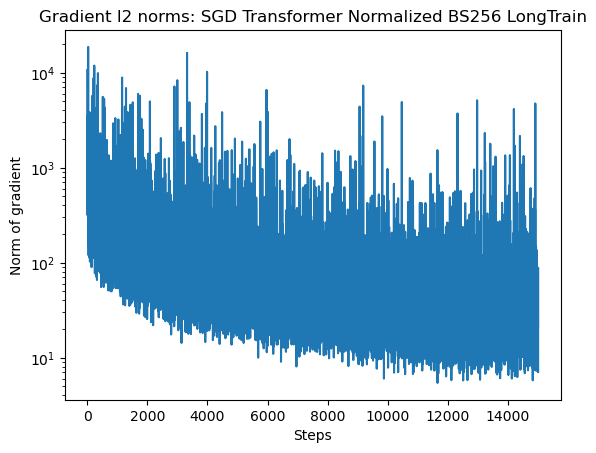

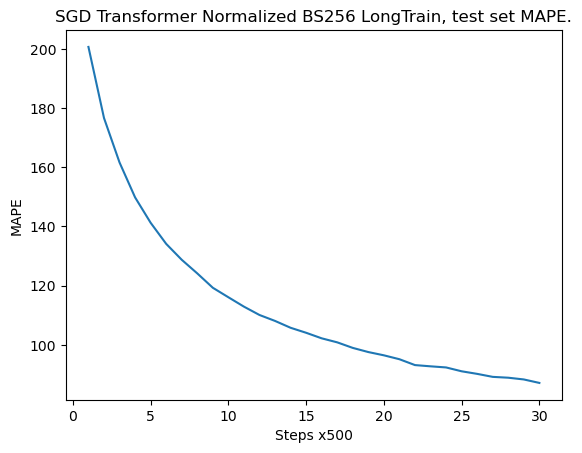

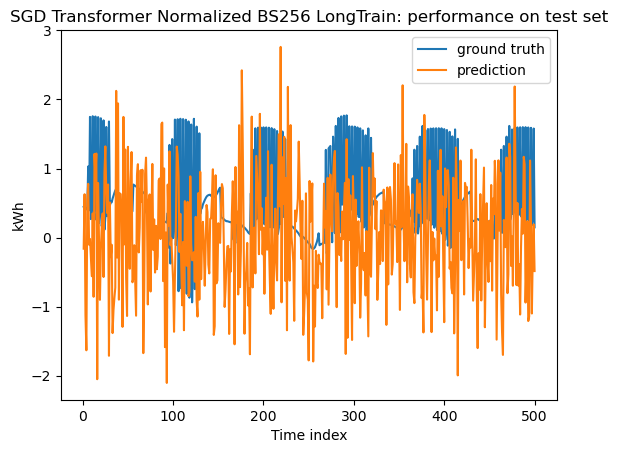

In [ ]:
o, p = train_and_test(
    'Transformer', # pass as the name containe in a string
    lstm_model_kwargs,
    'torch.optim.SGD', # pass as the name containe in a string
    {'lr': 5e-5},
    'SGD Transformer Normalized BS256 LongTrain',
    True,
    steps=15000,
    BS=256,
    ntype='z'
)

On experiment AdamW Transformer Normalized BS256 LongTrain, step 502, loss is 7.555165767669678.: : 502it [00:50,  1.68s/it] 

On step 500, MAPE error is 205.10718605735084 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 1002, loss is 5.332275390625.: : 1002it [01:40,  1.48s/it]   

On step 1000, MAPE error is 171.36739275672218 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 1506, loss is 4.536277770996094.: : 1503it [02:22,  1.06s/it] 

On step 1500, MAPE error is 150.50098570910367 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 2006, loss is 4.051008224487305.: : 2004it [02:51,  1.29it/s] 

On step 2000, MAPE error is 133.30710367722943 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 2506, loss is 2.7953202724456787.: : 2504it [03:20,  1.22it/s]

On step 2500, MAPE error is 119.95063695040616 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 3006, loss is 2.509794235229492.: : 3004it [03:49,  1.21it/s] 

On step 3000, MAPE error is 109.24199494448575 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 3506, loss is 2.190563678741455.: : 3504it [04:18,  1.29it/s] 

On step 3500, MAPE error is 100.8142352104187 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 4006, loss is 1.8612271547317505.: : 4003it [04:47,  1.04s/it]

On step 4000, MAPE error is 93.92522681843151 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 4506, loss is 1.8486649990081787.: : 4503it [05:16,  1.05s/it]

On step 4500, MAPE error is 87.59076161818071 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 5006, loss is 1.3675830364227295.: : 5005it [05:45,  1.34it/s]

On step 5000, MAPE error is 83.13022201711482 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 5506, loss is 1.8715343475341797.: : 5503it [06:15,  1.05s/it]

On step 5500, MAPE error is 78.79291068423878 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 6006, loss is 1.3747477531433105.: : 6006it [06:44,  1.36it/s]

On step 6000, MAPE error is 75.24190165779807 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 6506, loss is 0.9845735430717468.: : 6503it [07:13,  1.04s/it]

On step 6500, MAPE error is 73.31130829724398 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 7005, loss is 1.0723235607147217.: : 7005it [07:42,  1.25it/s]

On step 7000, MAPE error is 70.97337354313244 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 7506, loss is 1.714167833328247.: : 7504it [08:11,  1.35it/s] 

On step 7500, MAPE error is 69.37565857713872 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 8006, loss is 1.1868295669555664.: : 8004it [08:40,  1.33it/s]

On step 8000, MAPE error is 68.73286420648748 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 8506, loss is 1.30879807472229.: : 8504it [09:10,  1.25it/s]  

On step 8500, MAPE error is 66.74486344510859 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 9002, loss is 0.80385422706604.: : 9001it [09:39,  1.21s/it]  

On step 9000, MAPE error is 66.14636128598994 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 9506, loss is 0.9272706508636475.: : 9504it [10:08,  1.28it/s]

On step 9500, MAPE error is 64.31622180071744 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 10006, loss is 1.0993952751159668.: : 10004it [10:36,  1.35it/s]

On step 10000, MAPE error is 63.15082745118575 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 10506, loss is 0.927045464515686.: : 10503it [11:06,  1.04s/it] 

On step 10500, MAPE error is 63.84393518621271 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 11005, loss is 0.8354448676109314.: : 11005it [11:35,  1.18it/s]

On step 11000, MAPE error is 62.717460502277724 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 11505, loss is 1.282713532447815.: : 11504it [12:05,  1.24it/s] 

On step 11500, MAPE error is 63.12242963097312 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 12006, loss is 1.3196690082550049.: : 12006it [12:34,  1.34it/s] 

On step 12000, MAPE error is 64.01769518852234 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 12506, loss is 1.2319092750549316.: : 12505it [13:03,  1.33it/s]

On step 12500, MAPE error is 61.95520596070723 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 13006, loss is 0.7766294479370117.: : 13005it [13:32,  1.34it/s]

On step 13000, MAPE error is 61.28009449351918 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 13507, loss is 0.5448074340820312.: : 13504it [14:00,  1.14it/s]

On step 13500, MAPE error is 61.41347830945795 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 14006, loss is 1.0841350555419922.: : 14004it [14:29,  1.28it/s]

On step 14000, MAPE error is 61.585812135176226 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 14507, loss is 1.1030402183532715.: : 14504it [14:58,  1.16it/s] 

On step 14500, MAPE error is 61.93096258423545 percent.


On experiment AdamW Transformer Normalized BS256 LongTrain, step 15000, loss is 0.7165806293487549.: : 14999it [15:27, 16.17it/s]

On step 15000, MAPE error is 60.51400574770841 percent.


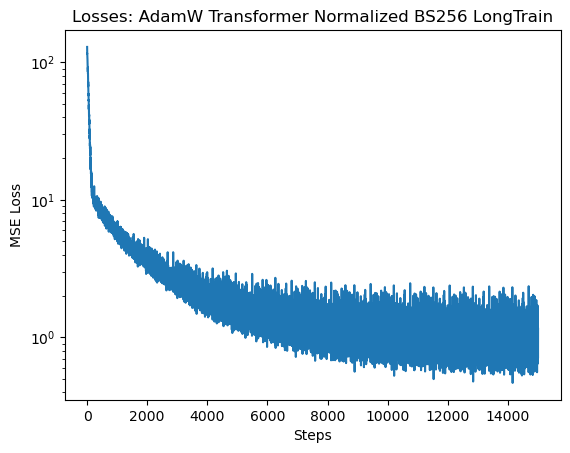

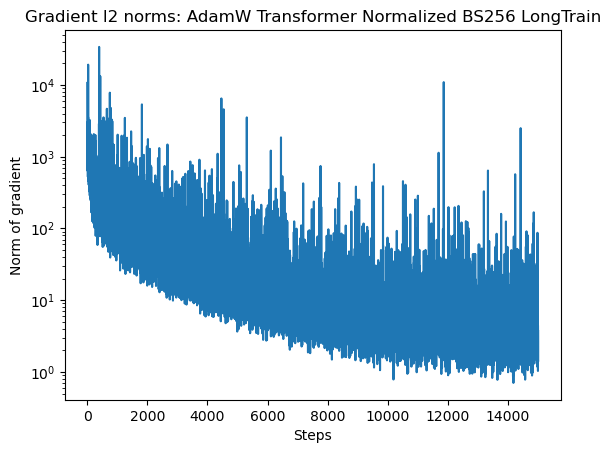

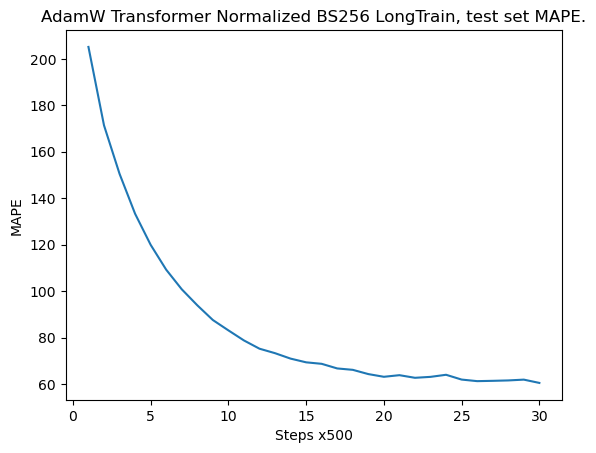

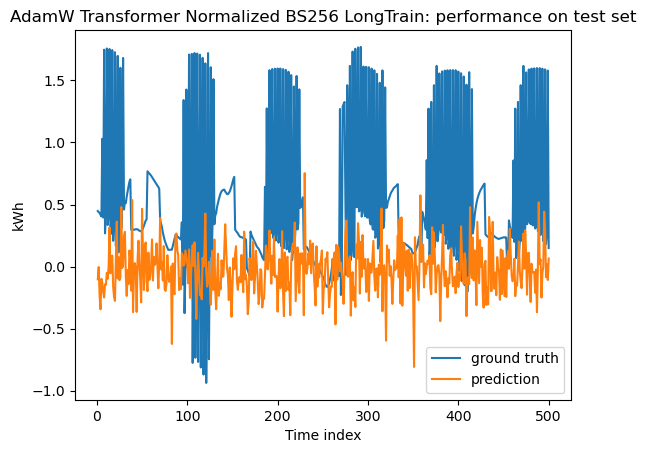

In [ ]:
o, p = train_and_test(
    'Transformer', # pass as the name containe in a string
    lstm_model_kwargs,
    'torch.optim.AdamW', # pass as the name containe in a string
    {'lr': 5e-5},
    'AdamW Transformer Normalized BS256 LongTrain',
    True,
    steps=15000,
    BS=256,
    ntype='z'
)